Script para sacar todo lo necesario para el proyecto 3

Importacion de librerias: 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Descripción del conjunto de datos

El archivo **todoscsvs.csv** reúne 10 años (2014–2023) de denuncias por violencia —incluyendo violencia intrafamiliar— registradas ante instituciones oficiales en Guatemala. Cada fila es una denuncia; cada columna, un atributo.

## Alcance temporal y geográfico
- **Periodo:** Enero 2014 – Diciembre 2023  
- **Ubicación:** Departamentos y municipios de Guatemala  

## Tamaño del dataset
- **Filas (observaciones):** corresponde a cada denuncia registrada  
- **Columnas (variables):** 70  

## Grupos de variables

| Categoría | Variables | Tipo de dato | Descripción breve |
|-----------|-----------|--------------|-------------------|
| 📅 Fecha ocurrencia | dia_ocurrencia, mes_ocurrencia, anio_ocurrencia | Categórico | Día, mes y año en que ocurrió el hecho |
| 📍 Ubicación ocurrencia | dep_municipio_ocurrencia | Categórico | Código (XXYY) de departamento+municipio donde ocurrió el hecho |
| 🚨 Tipo de agresión | tipo_agresion | Categórico | Código del tipo de agresión sufrida |
| 📅 Fecha registro | dia_registro, mes_registro, anio_registro | Categórico | Día, mes y año en que se registró la denuncia |
| 📍 Ubicación registro | dep_municipio_registro, departamento_registro | Categórico | Código municipio y departamento donde se registró la denuncia |
| 🗣 Reportante | quien_reporta | Categórico | Código de la persona que reportó el hecho |
| 👤 Víctima | sexo_victima, edad_victima, total_hijos_victima, hijos_hombres_victima, hijas_mujeres_victima, alfabeta_victima, escolaridad_victima, estado_civil_victima, pueblo_victima, nacionalidad_victima, trabaja_victima, ocupacion_victima, dedica_victima, discapacidad_victima, tipo_discapacidad_victima, relacion_victima_agresor, otras_victimas_total, otras_victimas_hombres, otras_victimas_mujeres, otras_victimas_ninos, otras_victimas_ninas | Mixto | Datos demográficos y contexto de la víctima |
| 👥 Agresor | sexo_agresor, edad_agresor, alfabeta_agresor, escolaridad_agresor, estado_civil_agresor, AGR_GURPET (pueblo_agresor), nacionalidad_agresor, trabaja_agresor, ocupacion_agresor, dedica_agresor, otros_agresores_total, otros_agresores_hombres, otros_agresores_mujeres, otros_agresores_ninos, otros_agresores_ninas | Mixto | Datos demográficos y contexto del agresor |
| 🏛 Instituciones | institucion_denuncia_previa, institucion_registro, organismo_jurisdiccional, conducente, organismo_remite | Categórico | Instituciones involucradas en la denuncia |
| 📜 Legislación y medidas | ley_aplicable, medidas_seguridad, tipo_medida, ARTICULOVCM1–4, ARTICULOCODPEN1–4, ARTICULOTRAS1–4 | Categórico | Leyes aplicadas y medidas judiciales |
| 🔢 Identificación | numero_boleta | Numérico | Folio interno de la denuncia |


Leer datos de un csv

In [23]:
df = pd.read_csv("todoscsvs.csv", low_memory=False)

# - Analisis Exploratorio #

- Corregir tipos de datos

In [ ]:
for prefix in ("ocurrencia", "registro"):
    for unit in ("dia", "mes", "anio"):
        col = f"{unit}_{prefix}"
        df[col] = df[col].astype("Int64").astype("category")

# Crear columnas datetime completas
df["fecha_ocurrencia"] = pd.to_datetime(
    df[['anio_ocurrencia','mes_ocurrencia','dia_ocurrencia']]
      .rename(columns={'anio_ocurrencia':'year','mes_ocurrencia':'month','dia_ocurrencia':'day'}),
    errors='coerce'
)
df["fecha_registro"] = pd.to_datetime(
    df[['anio_registro','mes_registro','dia_registro']]
      .rename(columns={'anio_registro':'year','mes_registro':'month','dia_registro':'day'}),
    errors='coerce'
)

# Separar códigos departamento/municipio (formato XXYY)
for col, dep, mun in [
    ("dep_municipio_ocurrencia", "cod_dep_ocurrencia", "cod_mun_ocurrencia"),
    ("dep_municipio_registro",   "cod_dep_registro",   "cod_mun_registro")
]:
    df[[dep, mun]] = (
        df[col].astype(str).str.zfill(4).str.extract(r'^(\d{2})(\d{2})$')
    )

# Convertir todas las columnas de texto y códigos a categoría
cat_cols = df.select_dtypes(include="object").columns.tolist() + [
    "cod_dep_ocurrencia", "cod_mun_ocurrencia", "cod_dep_registro", "cod_mun_registro"
]
for c in cat_cols:
    if c in df.columns:
        df[c] = df[c].astype("category")

- Visión general

In [29]:
print("📊 Dimensiones del dataset:", df.shape)
print("\n🔍 Conteo por tipo de dato:")
display(df.dtypes.value_counts())

print("\n📋 Primeras 5 filas:")
display(df.head())

print("\n❓ Valores faltantes:")
missing = df.isna().sum().sort_values(ascending=False)
display(missing[missing > 0].to_frame("faltantes"))

print("\n📈 Estadísticas descriptivas (todas las variables):")
display(df.describe(include='all').T)

print("\nℹ️ Información completa:")
df.info()

📊 Dimensiones del dataset: (328959, 76)

🔍 Conteo por tipo de dato:


float64           56
category           4
category           2
datetime64[ns]     2
category           1
category           1
category           1
category           1
category           1
category           1
category           1
category           1
category           1
category           1
category           1
category           1
Name: count, dtype: int64


📋 Primeras 5 filas:


,dia_ocurrencia,mes_ocurrencia,anio_ocurrencia,dep_municipio_ocurrencia,tipo_agresion,dia_registro,mes_registro,anio_registro,dep_municipio_registro,quien_reporta,...,ARTICULOTRAS4,organismo_remite,numero_boleta,departamento_registro,fecha_ocurrencia,fecha_registro,cod_dep_ocurrencia,cod_mun_ocurrencia,cod_dep_registro,cod_mun_registro
0,4,2,2014,1708.0,1122.0,5,2,2014,1101.0,3.0,...,NaN,NaN,NaN,NaN,2014-02-04,2014-02-05,NaN,NaN,NaN,NaN
1,12,1,2014,1505.0,2122.0,12,2,2014,1505.0,2.0,...,NaN,NaN,NaN,NaN,2014-01-12,2014-02-12,NaN,NaN,NaN,NaN
2,8,4,2014,501.0,1122.0,8,4,2014,501.0,3.0,...,NaN,NaN,NaN,NaN,2014-04-08,2014-04-08,NaN,NaN,NaN,NaN
3,14,4,2014,1107.0,1122.0,14,4,2014,1101.0,3.0,...,NaN,NaN,NaN,NaN,2014-04-14,2014-04-14,NaN,NaN,NaN,NaN
4,14,4,2014,1101.0,1122.0,15,4,2014,1101.0,3.0,...,NaN,NaN,NaN,NaN,2014-04-14,2014-04-15,NaN,NaN,NaN,NaN



❓ Valores faltantes:


,faltantes
cod_mun_registro,328959
cod_dep_registro,328959
cod_mun_ocurrencia,328959
cod_dep_ocurrencia,328959
ARTICULOTRAS2,326868
ARTICULOTRAS3,326868
ARTICULOTRAS4,326868
ARTICULOTRAS1,326868
ARTICULOCODPEN1,326010
ARTICULOCODPEN4,326010



📈 Estadísticas descriptivas (todas las variables):


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
dia_ocurrencia,328959.0,32.0,1.0,13745.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mes_ocurrencia,328959.0,13.0,5.0,28816.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
anio_ocurrencia,328959.0,25.0,2022.0,36565.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dep_municipio_ocurrencia,328959.0,NaN,NaN,NaN,888.149076,1.0,115.0,903.0,1504.0,9999.0,848.898045
tipo_agresion,328959.0,15.0,2122.0,134890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
fecha_registro,328959,NaN,NaN,NaN,2019-02-13 21:53:37.126754560,2014-01-01 00:00:00,2016-06-27 00:00:00,2019-03-16 00:00:00,2021-10-13 00:00:00,2023-12-31 00:00:00,NaN
cod_dep_ocurrencia,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cod_mun_ocurrencia,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cod_dep_registro,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN



ℹ️ Información completa:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328959 entries, 0 to 328958
Data columns (total 76 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   dia_ocurrencia               328959 non-null  category      
 1   mes_ocurrencia               328959 non-null  category      
 2   anio_ocurrencia              328959 non-null  category      
 3   dep_municipio_ocurrencia     328959 non-null  float64       
 4   tipo_agresion                328959 non-null  category      
 5   dia_registro                 328959 non-null  category      
 6   mes_registro                 328959 non-null  category      
 7   anio_registro                328959 non-null  category      
 8   dep_municipio_registro       328959 non-null  float64       
 9   quien_reporta                328959 non-null  float64       
 10  sexo_victima                 328959 non-null  category      
 11  

- Resumen de las variables numéricas


📊 Estadísticas descriptivas — Variables numéricas


,count,mean,std,min,25%,50%,75%,max
dep_municipio_ocurrencia,328959.0,888.149076,848.898045,1.0,115.0,903.0,1504.0,9999.0
dep_municipio_registro,328959.0,958.244632,656.962671,101.0,309.0,1003.0,1601.0,2217.0
quien_reporta,328959.0,1.122678,0.873304,1.0,1.0,1.0,1.0,9.0
edad_victima,328959.0,34.759882,15.319914,1.0,24.0,31.0,41.0,99.0
total_hijos_victima,327285.0,21.595903,38.896868,0.0,1.0,2.0,5.0,99.0
hijos_hombres_victima,327285.0,20.791683,39.283444,0.0,0.0,1.0,3.0,99.0
hijas_mujeres_victima,327285.0,20.737308,39.307766,0.0,0.0,1.0,3.0,99.0
alfabeta_victima,328274.0,1.216280,0.759857,1.0,1.0,1.0,1.0,9.0
escolaridad_victima,328274.0,32.093760,17.802340,10.0,23.0,29.0,45.0,99.0
ocupacion_victima,112824.0,6375.044166,2421.276445,110.0,5142.0,5412.0,9111.0,9999.0



🔬 Prueba de normalidad (Shapiro–Wilk)
dep_municipio_ocurrencia: W=0.7391, p=0.0000 (No normal)
dep_municipio_registro: W=0.9226, p=0.0000 (No normal)
quien_reporta: W=0.1207, p=0.0000 (No normal)
edad_victima: W=0.8623, p=0.0000 (No normal)
total_hijos_victima: W=0.5228, p=0.0000 (No normal)
hijos_hombres_victima: W=0.5109, p=0.0000 (No normal)
hijas_mujeres_victima: W=0.5104, p=0.0000 (No normal)
alfabeta_victima: W=0.2631, p=0.0000 (No normal)
escolaridad_victima: W=0.8463, p=0.0000 (No normal)
ocupacion_victima: W=0.9168, p=0.0000 (No normal)
dedica_victima: W=0.2182, p=0.0000 (No normal)
discapacidad_victima: W=0.2118, p=0.0000 (No normal)
tipo_discapacidad_victima: W=0.4668, p=0.0000 (No normal)
otras_victimas_total: W=0.6302, p=0.0000 (No normal)
otras_victimas_hombres: W=0.6205, p=0.0000 (No normal)
otras_victimas_mujeres: W=0.6214, p=0.0000 (No normal)
otras_victimas_ninos: W=0.6237, p=0.0000 (No normal)
otras_victimas_ninas: W=0.6234, p=0.0000 (No normal)
area_ocurrencia: W=0

C:\Users\sofia\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 328959.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\sofia\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 327285.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\sofia\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 328274.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\sofia\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 112824.
  res = hypotest_fun_out(*samples, **kwds)
C:\U

sexo_agresor: W=0.4354, p=0.0000 (No normal)
edad_agresor: W=0.7663, p=0.0000 (No normal)
alfabeta_agresor: W=0.2468, p=0.0000 (No normal)
escolaridad_agresor: W=0.8023, p=0.0000 (No normal)
estado_civil_agresor: W=0.7008, p=0.0000 (No normal)
AGR_GURPET: W=0.6022, p=0.0000 (No normal)
nacionalidad_agresor: W=0.1429, p=0.0000 (No normal)
trabaja_agresor: W=0.3398, p=0.0000 (No normal)
ocupacion_agresor: W=0.9300, p=0.0000 (No normal)
dedica_agresor: W=0.7096, p=0.0000 (No normal)
otros_agresores_total: W=0.6390, p=0.0000 (No normal)
otros_agresores_hombres: W=0.6375, p=0.0000 (No normal)
otros_agresores_mujeres: W=0.6378, p=0.0000 (No normal)
otros_agresores_ninos: W=0.6368, p=0.0000 (No normal)
otros_agresores_ninas: W=0.6367, p=0.0000 (No normal)
institucion_registro: W=0.7027, p=0.0000 (No normal)
ley_aplicable: W=0.5729, p=0.0000 (No normal)
medidas_seguridad: W=0.1694, p=0.0000 (No normal)
organismo_jurisdiccional: W=0.4836, p=0.0000 (No normal)
conducente: W=0.4518, p=0.0000 (No 

C:\Users\sofia\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 328935.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\sofia\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 257828.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\sofia\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 75522.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\sofia\AppData\Roaming\Python\Python313\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 180548.
  res = hypotest_fun_out(*samples, **kwds)
C:\Us

ARTICULOCODPEN4: W=0.5678, p=0.0000 (No normal)
ARTICULOTRAS1: W=0.0235, p=0.0000 (No normal)
ARTICULOTRAS2: W=0.0236, p=0.0000 (No normal)
ARTICULOTRAS3: W=0.0235, p=0.0000 (No normal)
ARTICULOTRAS4: W=0.0235, p=0.0000 (No normal)
organismo_remite: W=0.6419, p=0.0000 (No normal)
numero_boleta: W=0.3511, p=0.0000 (No normal)
departamento_registro: W=0.8964, p=0.0000 (No normal)


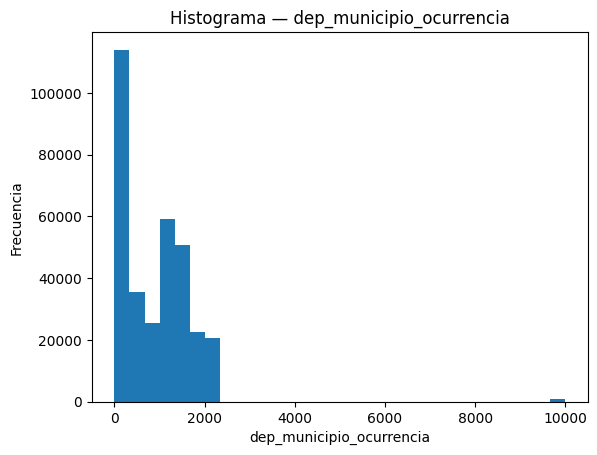

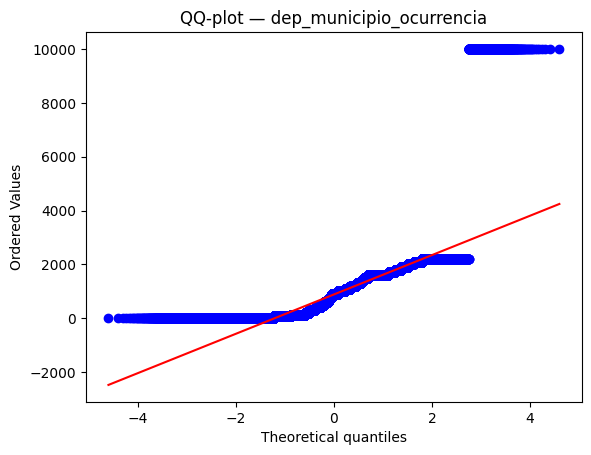

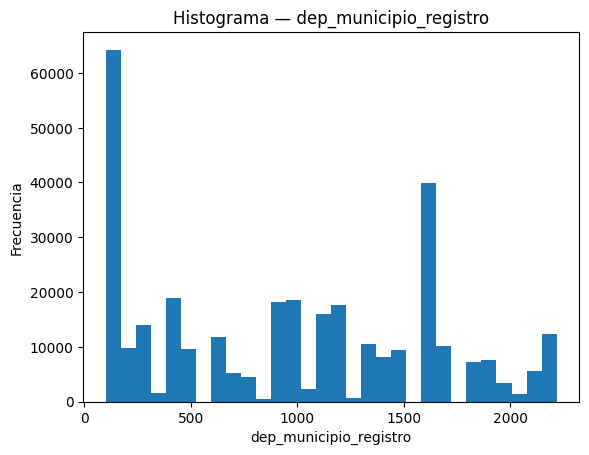

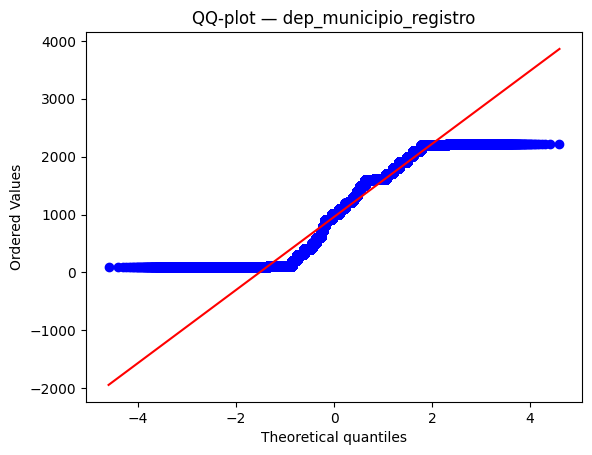

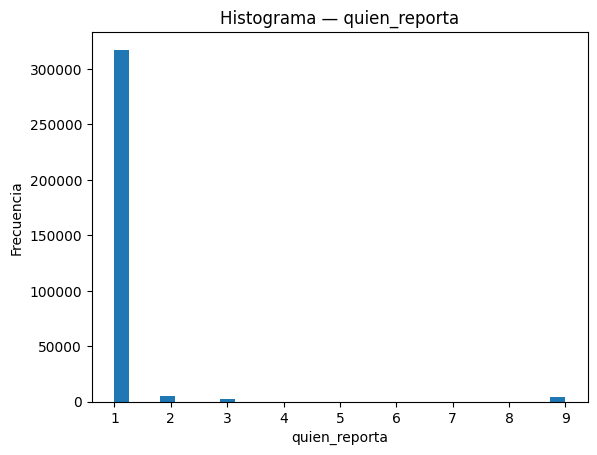

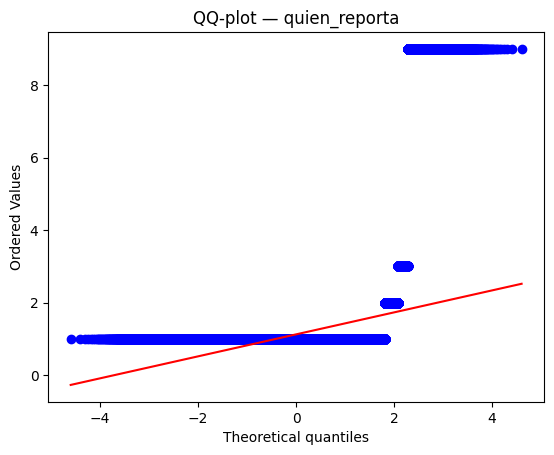

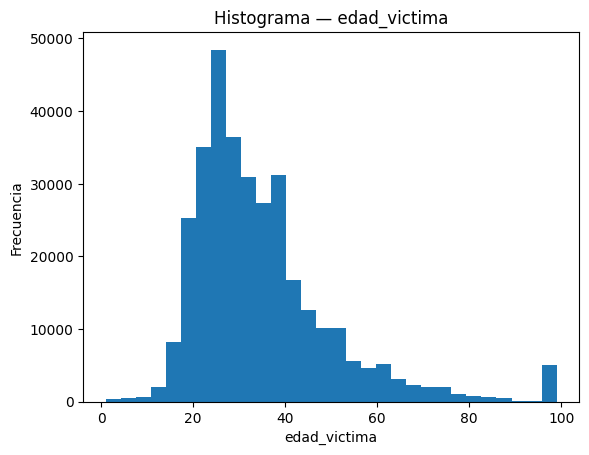

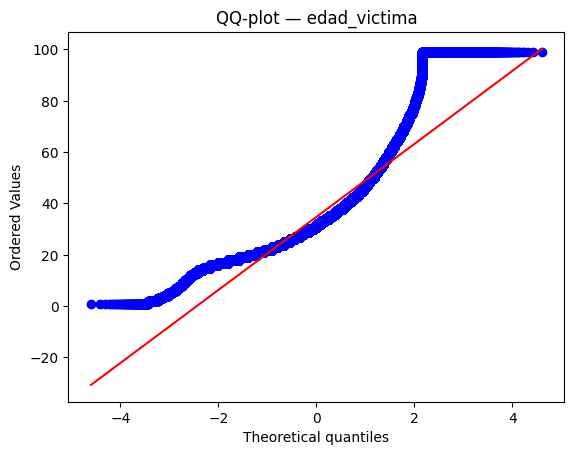

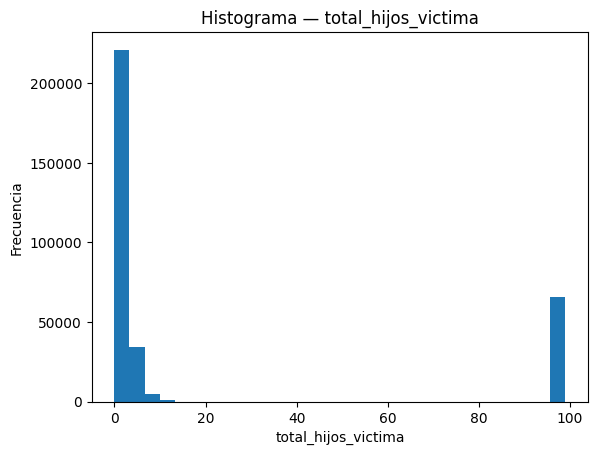

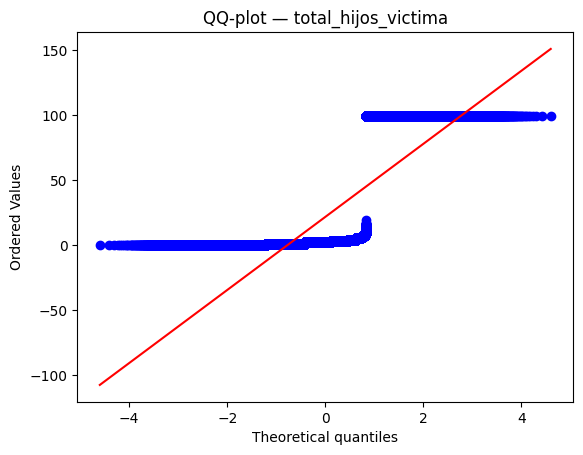

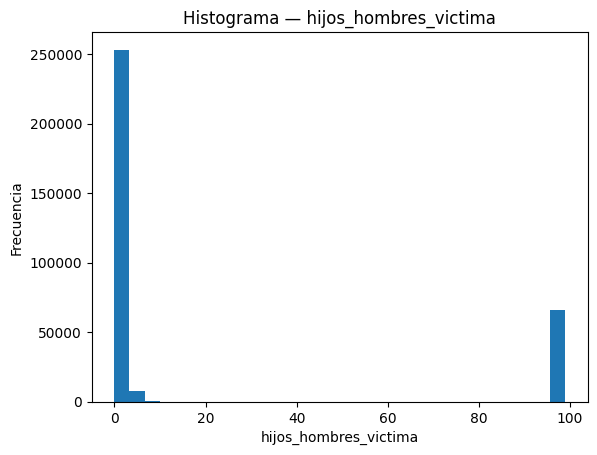

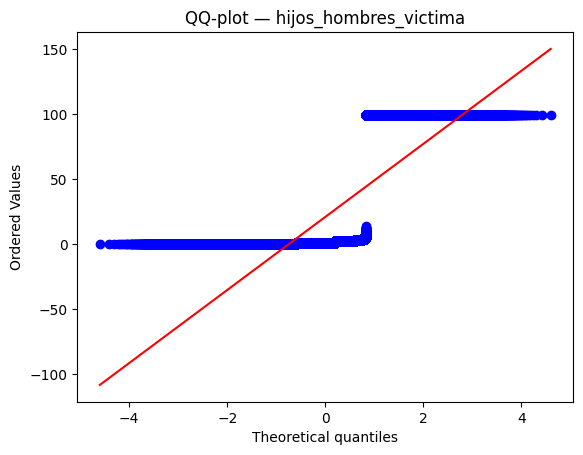

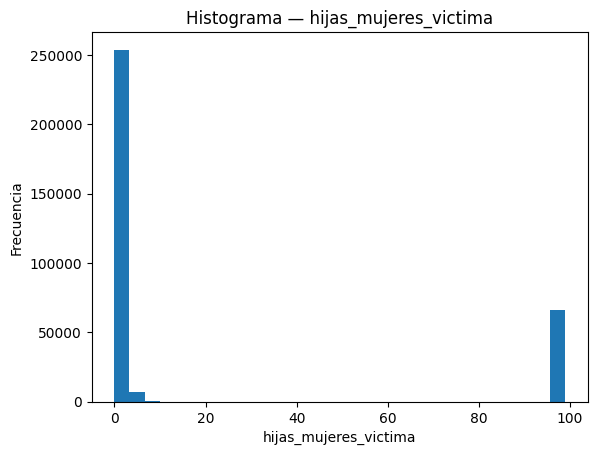

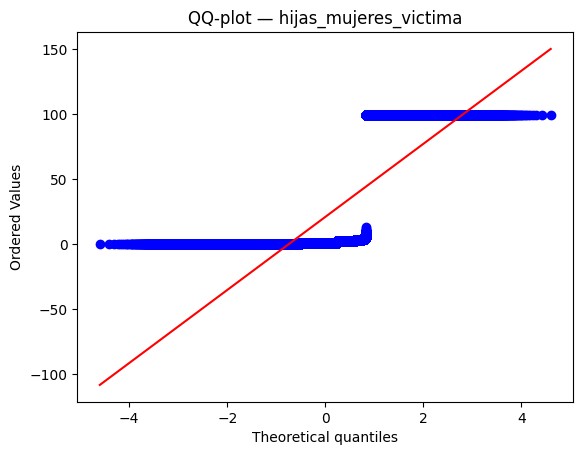

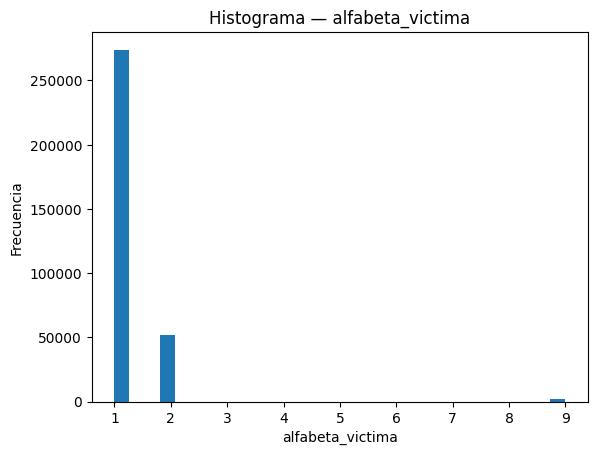

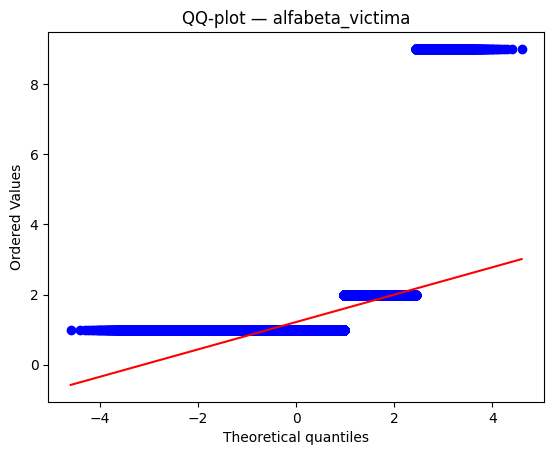

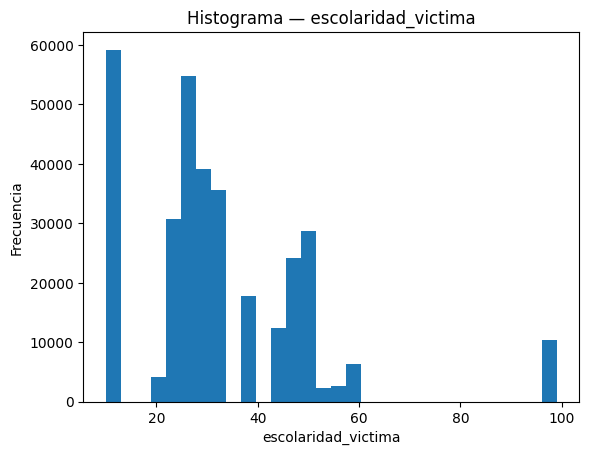

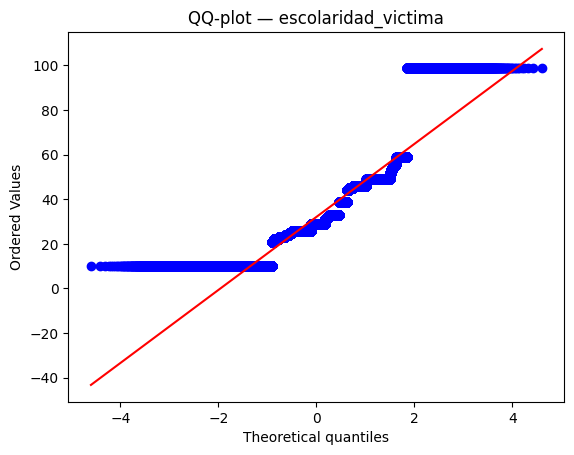

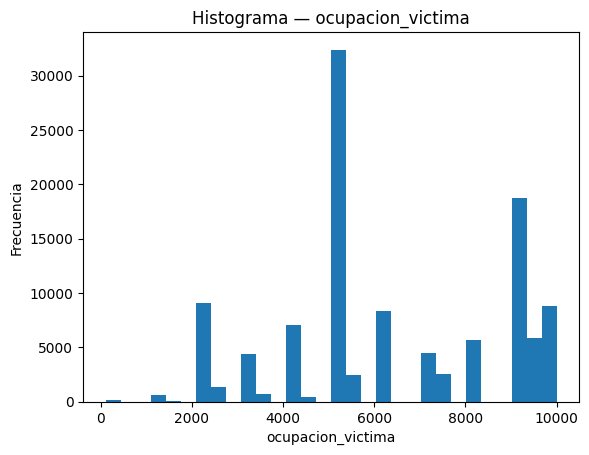

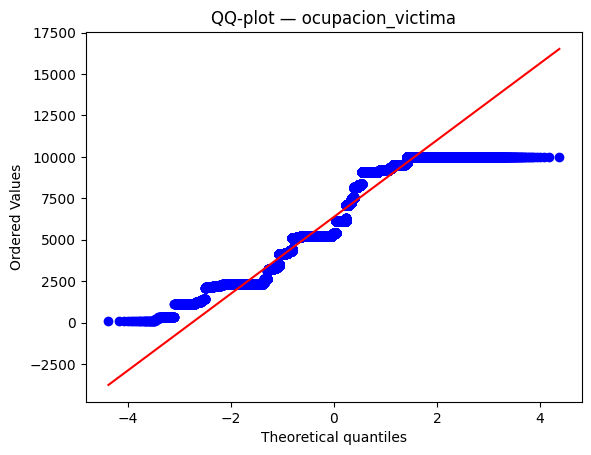

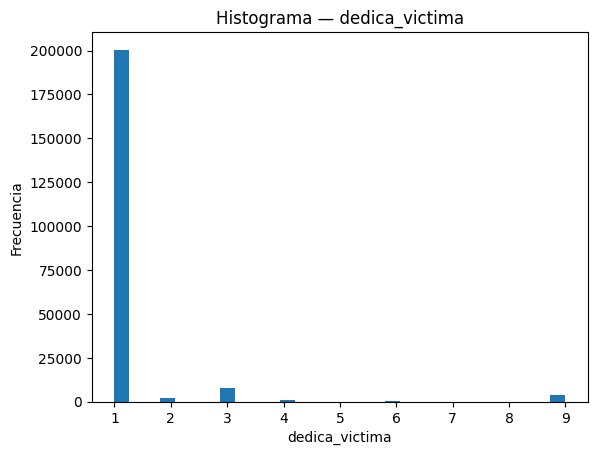

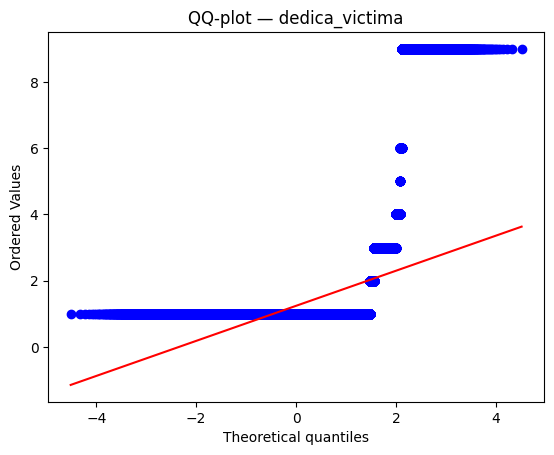

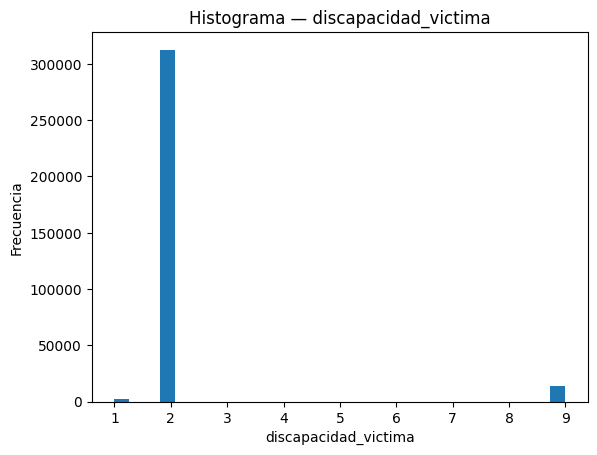

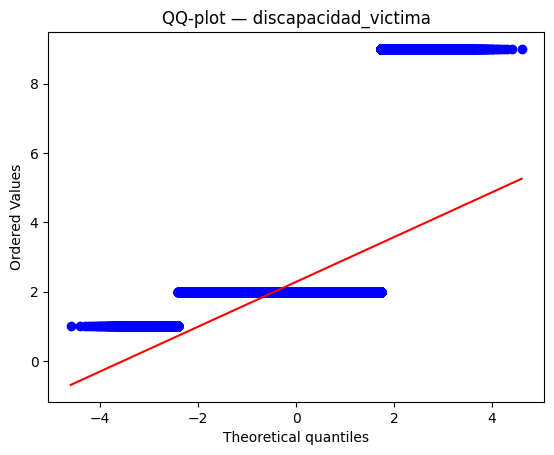

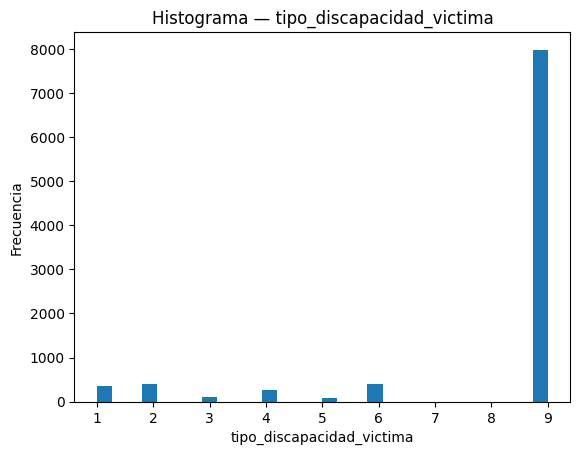

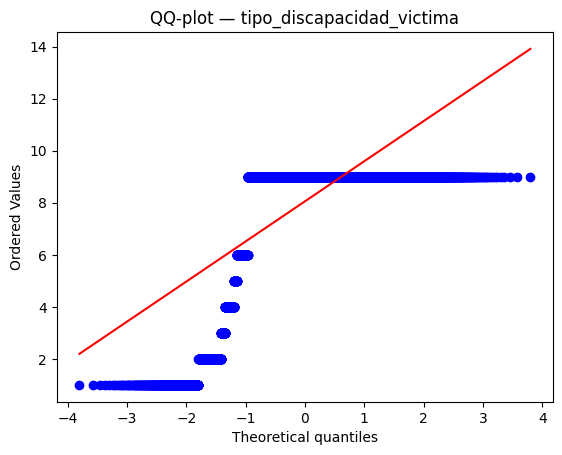

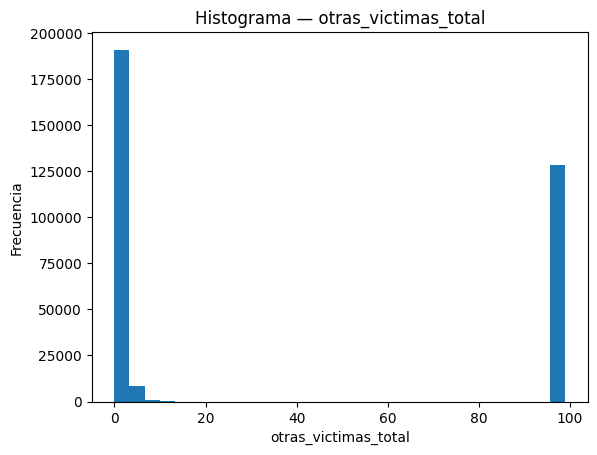

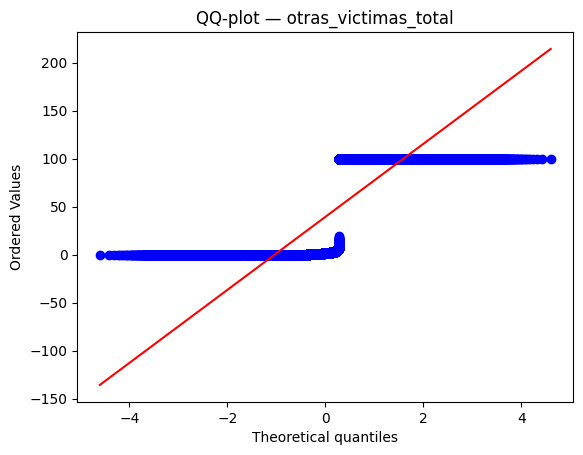

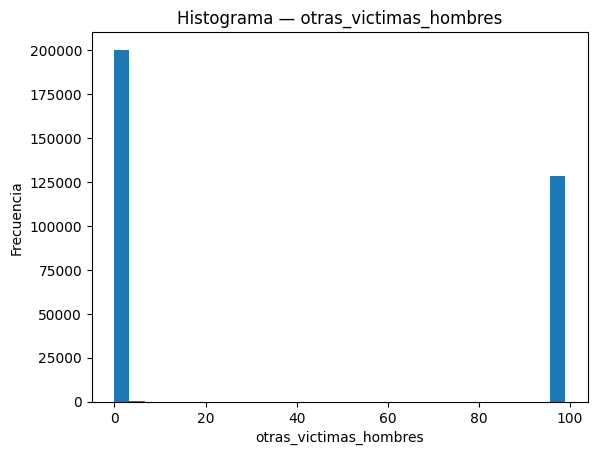

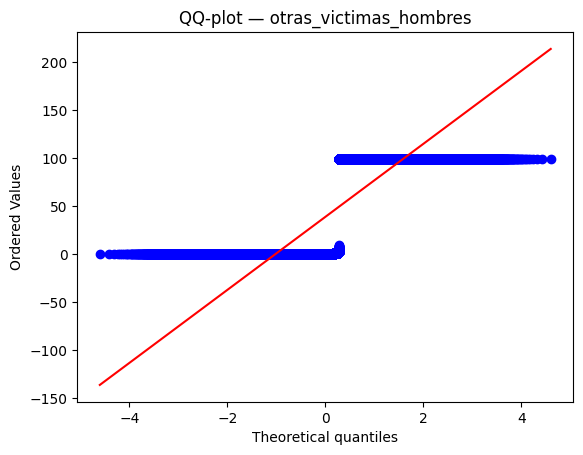

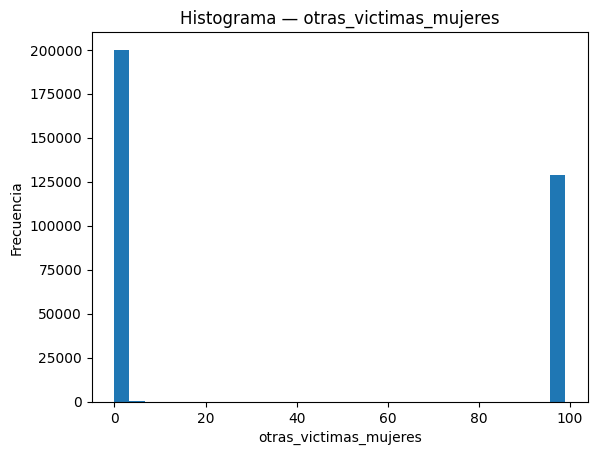

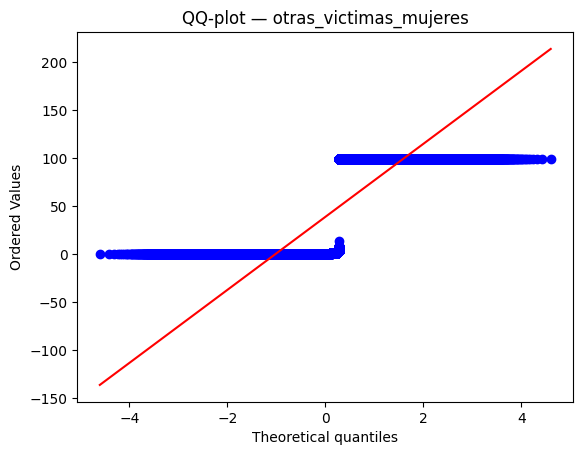

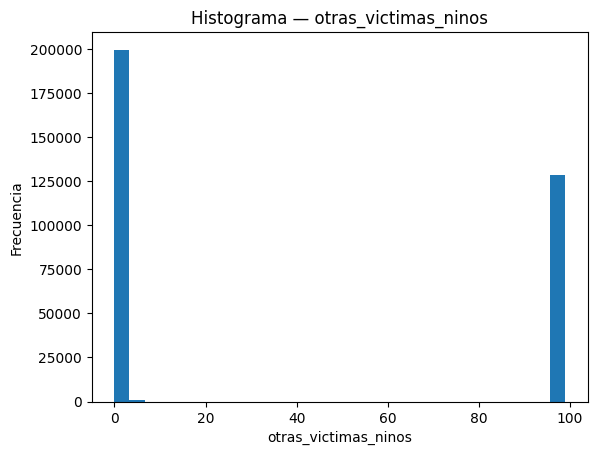

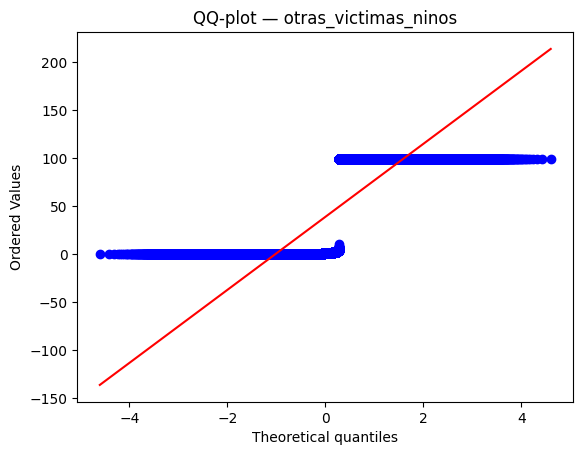

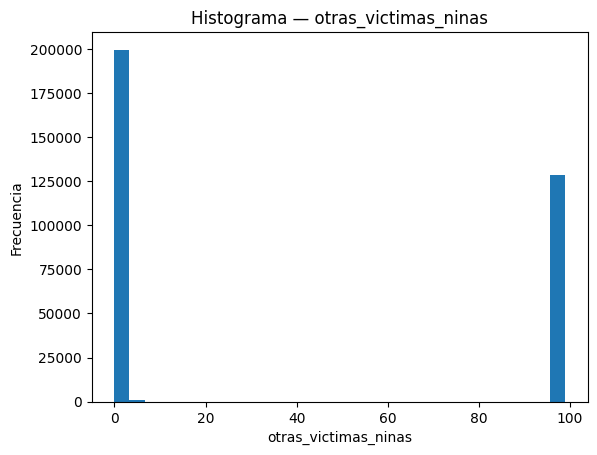

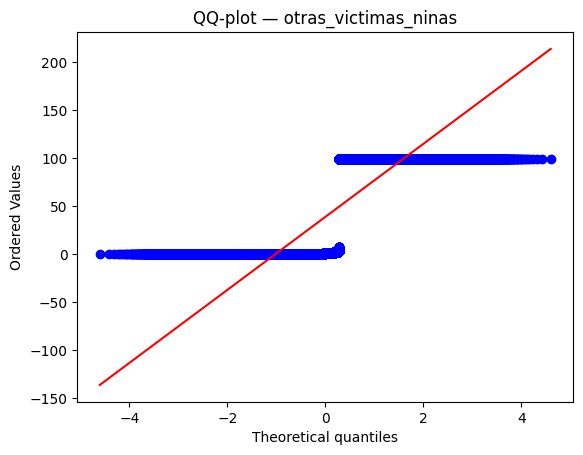

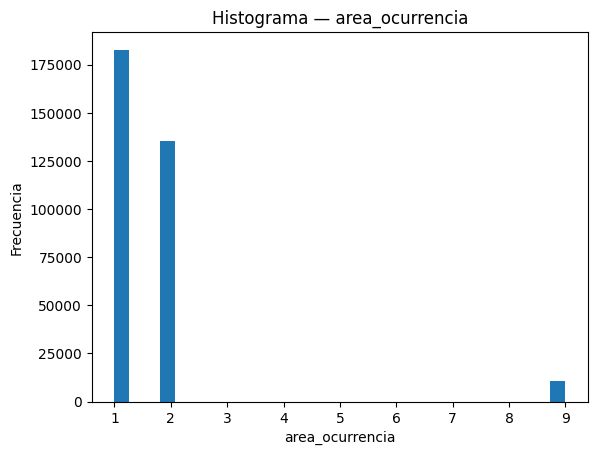

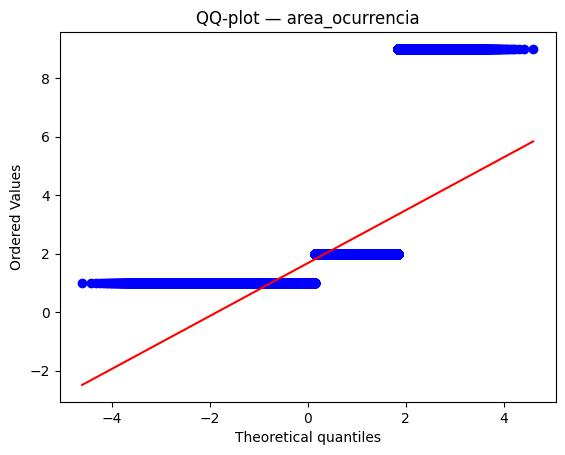

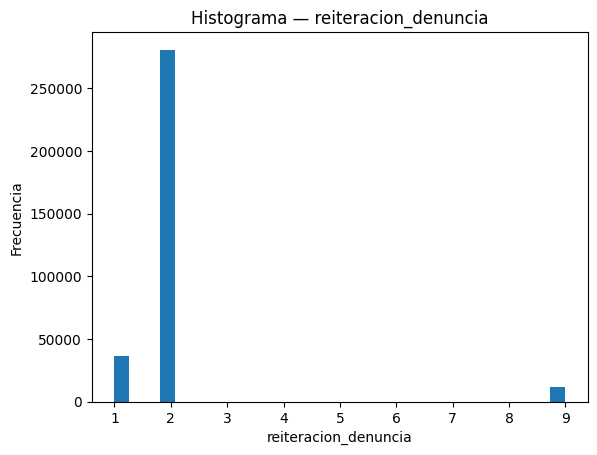

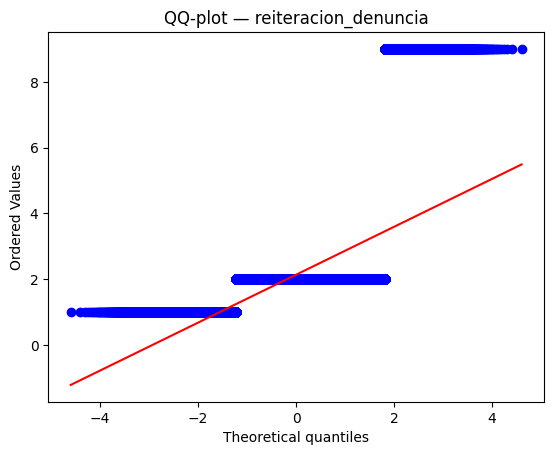

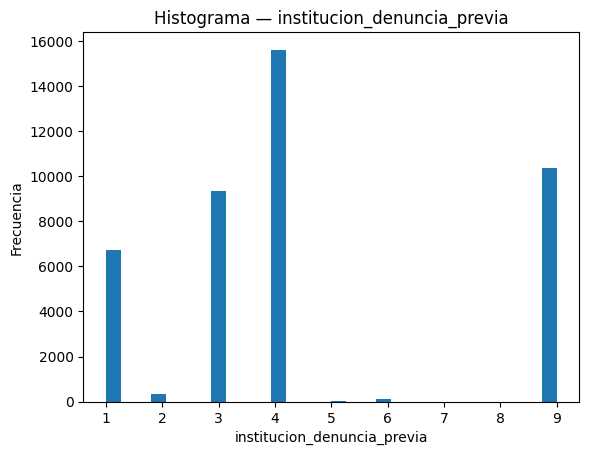

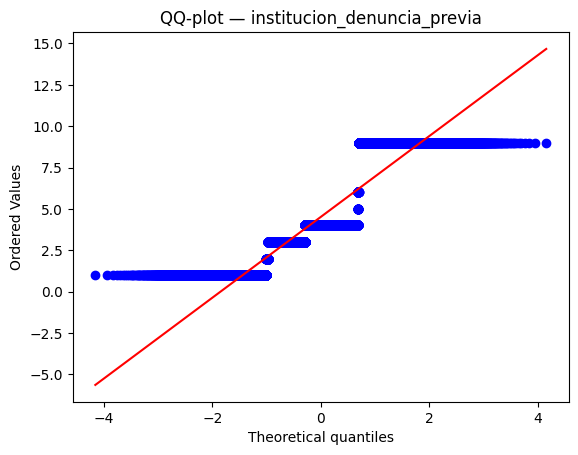

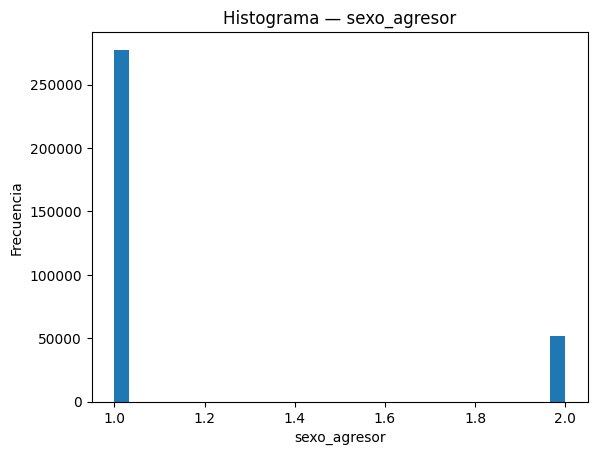

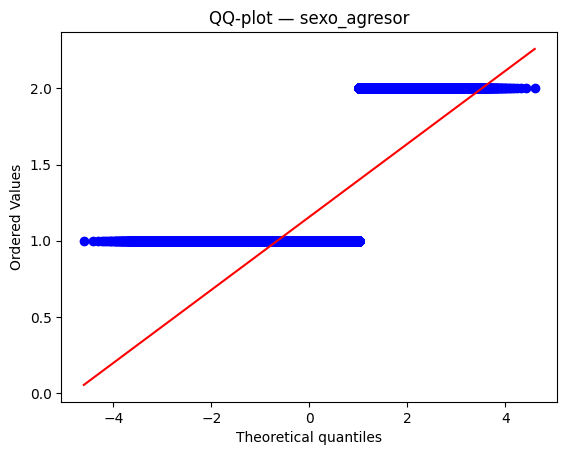

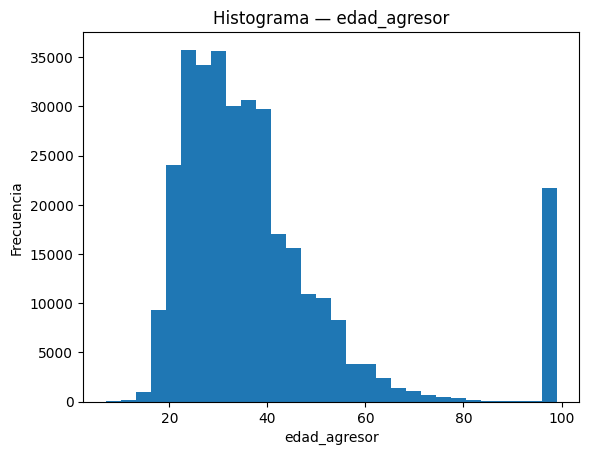

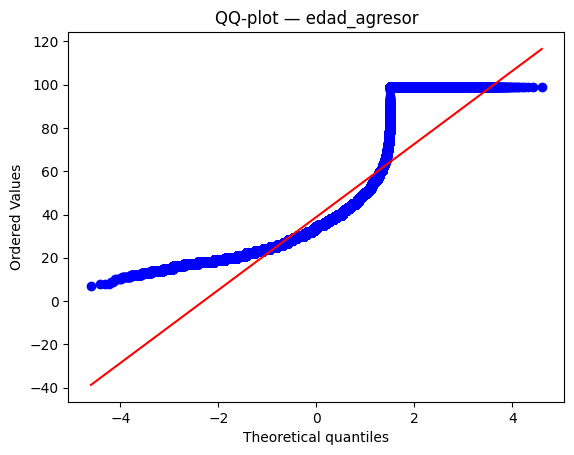

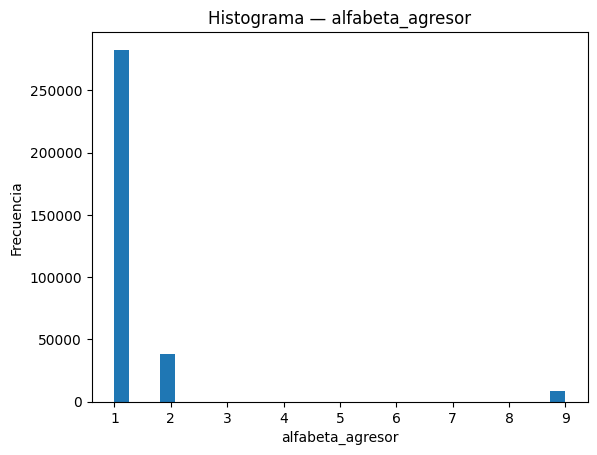

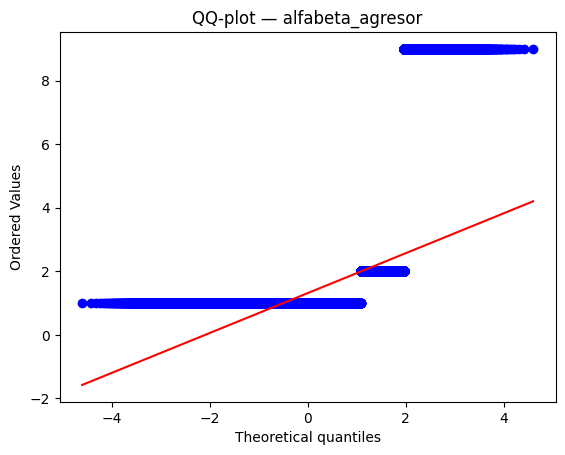

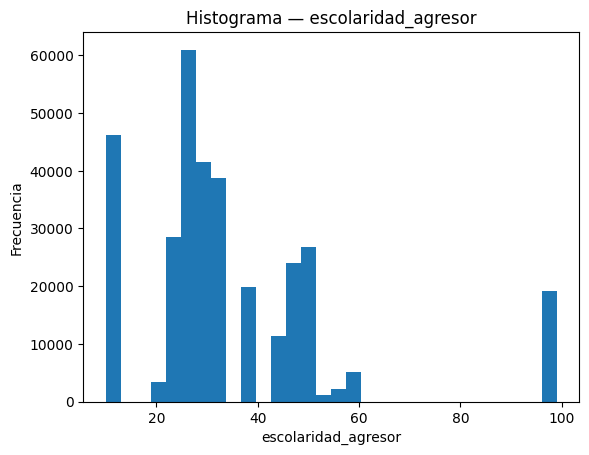

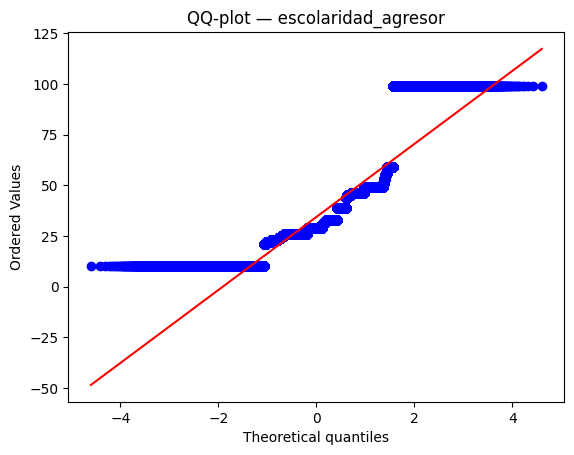

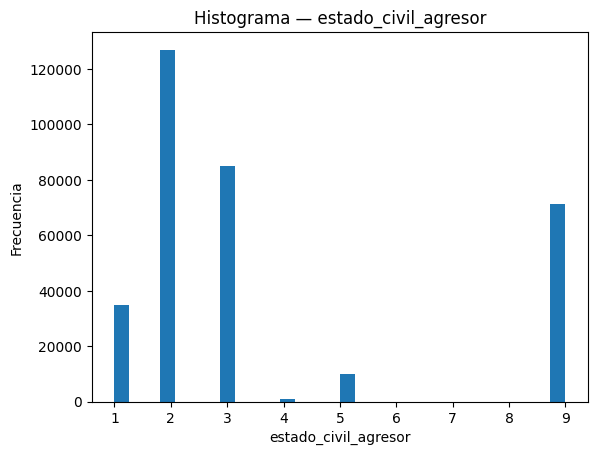

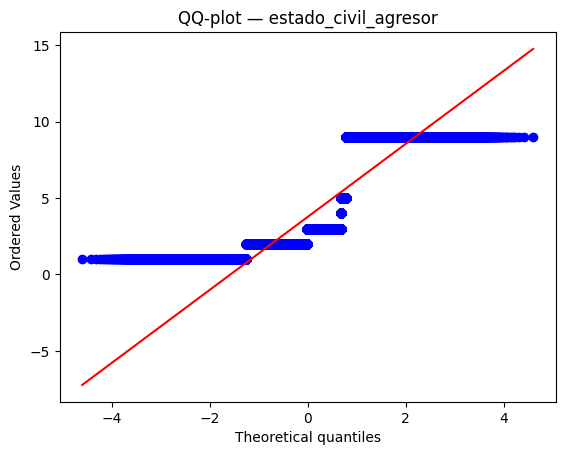

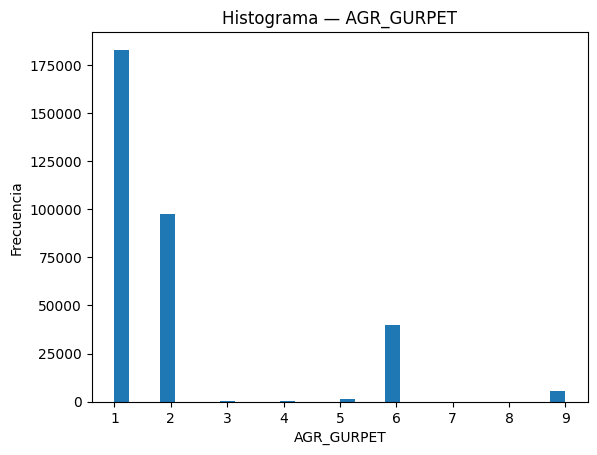

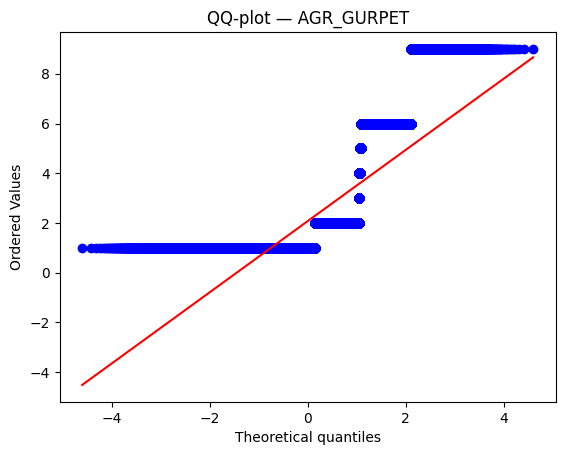

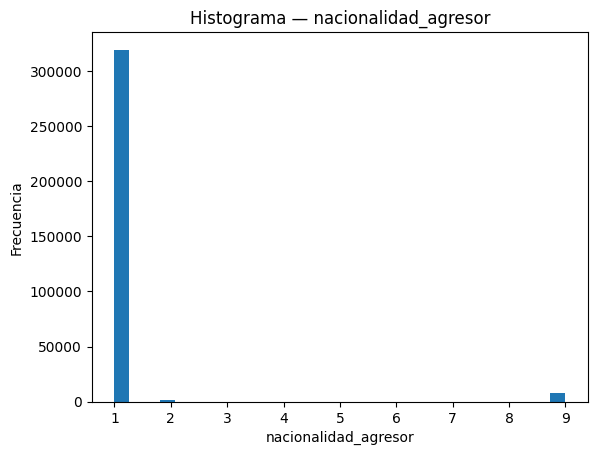

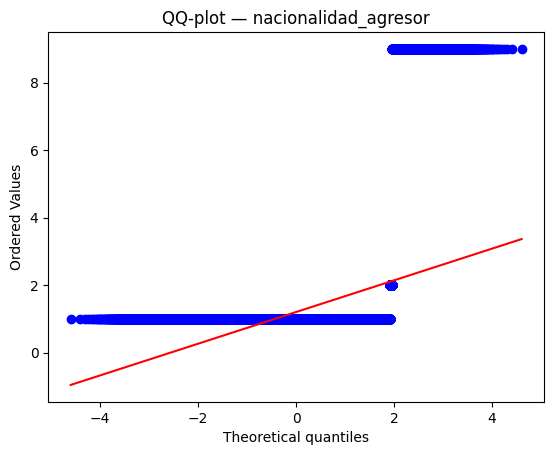

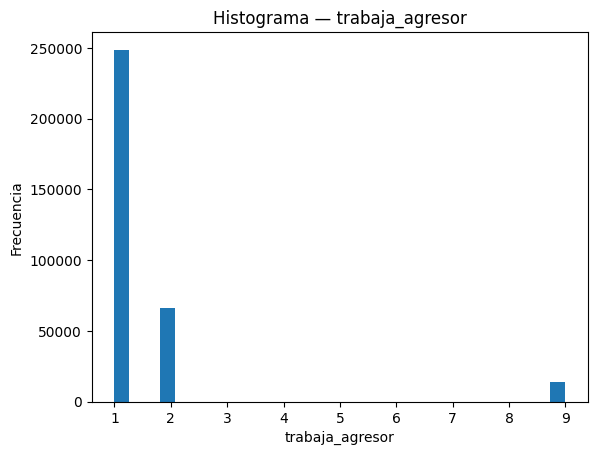

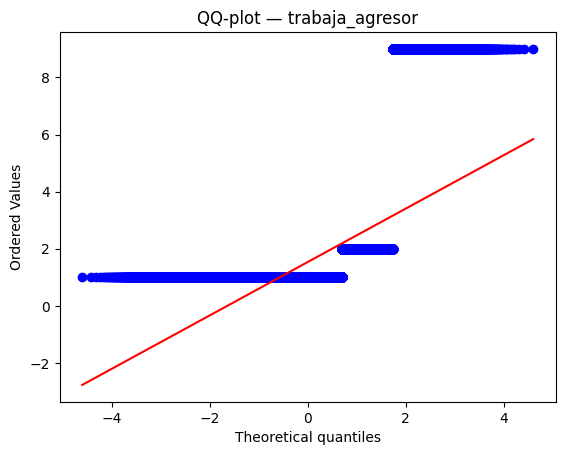

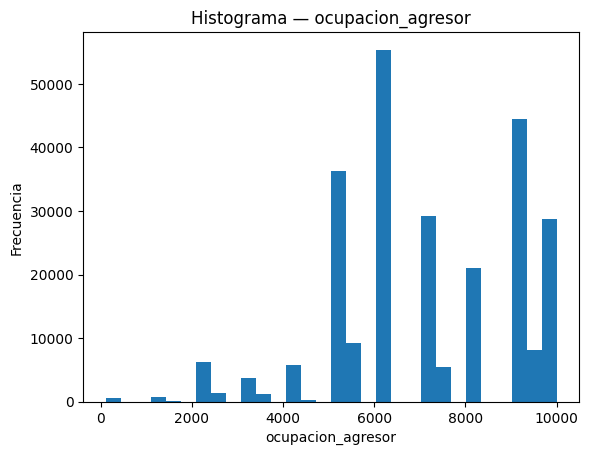

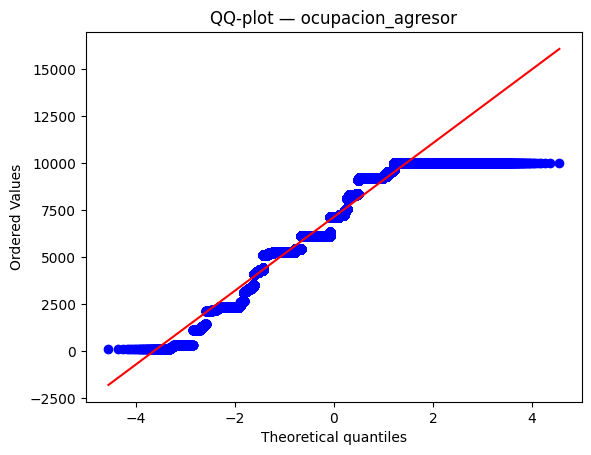

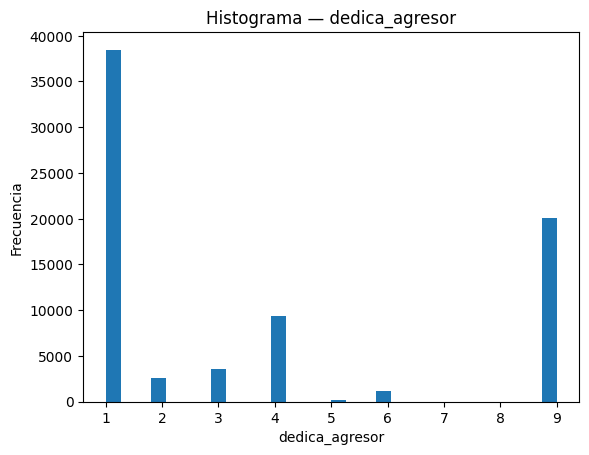

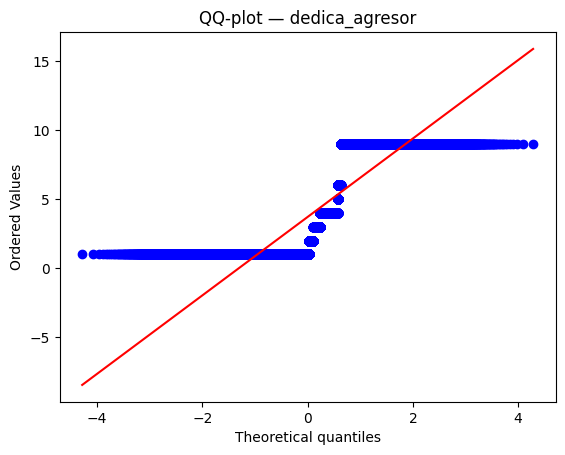

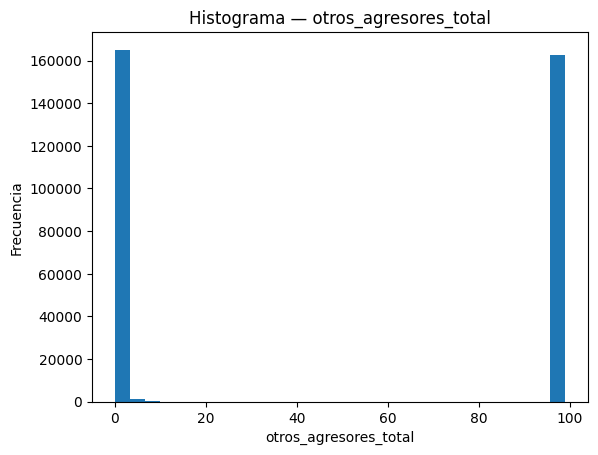

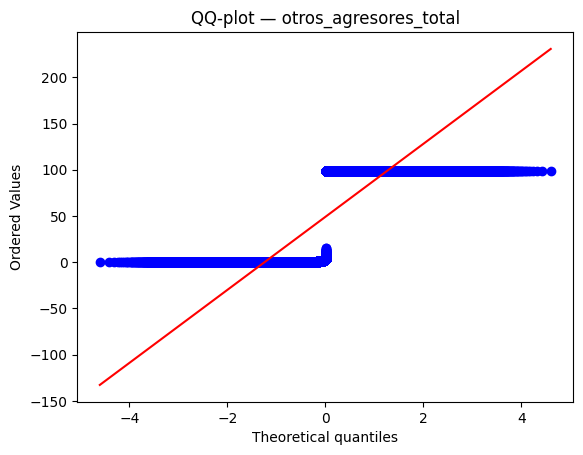

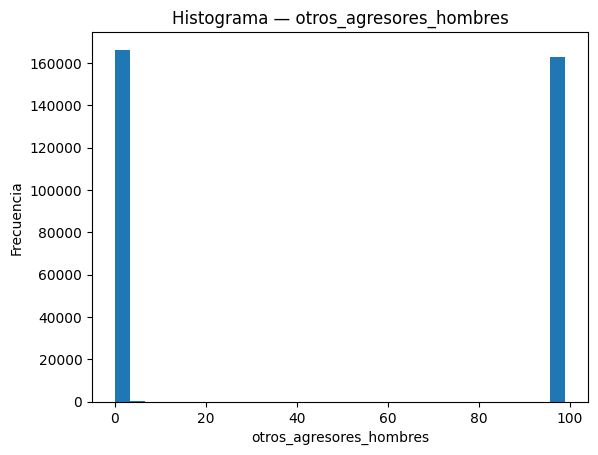

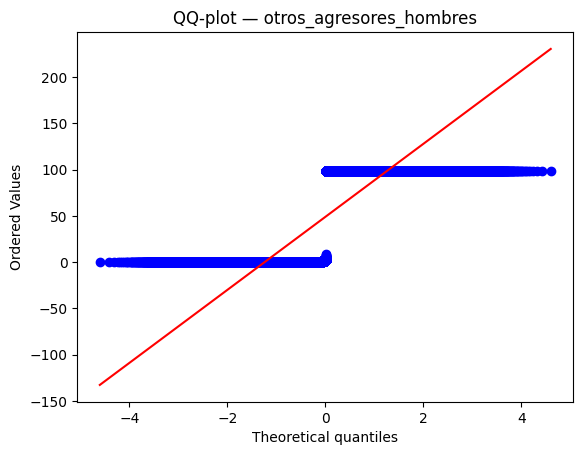

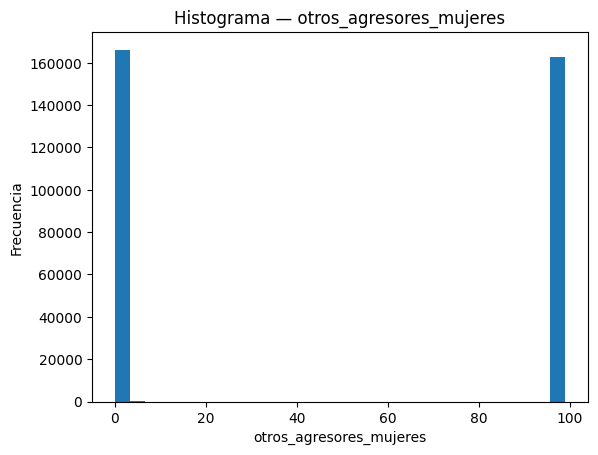

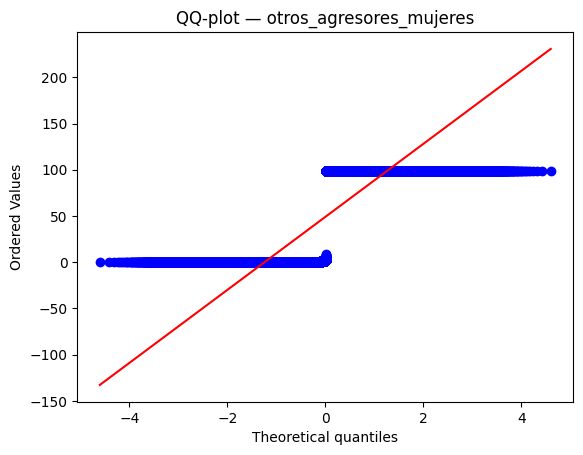

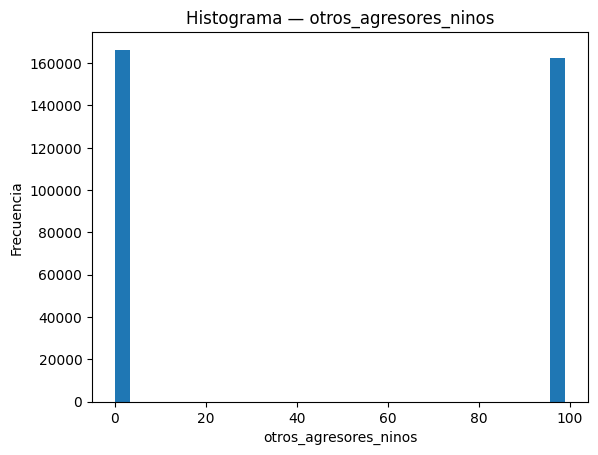

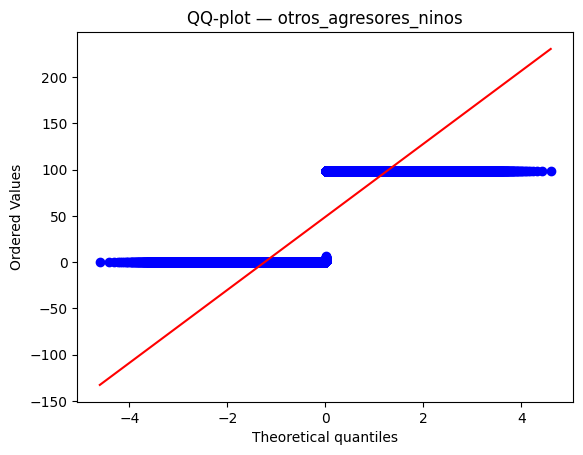

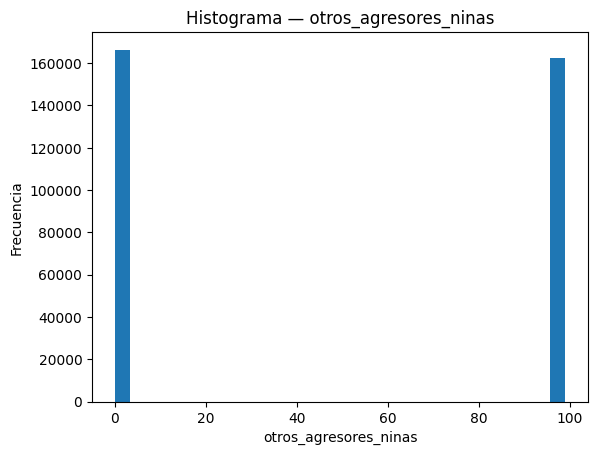

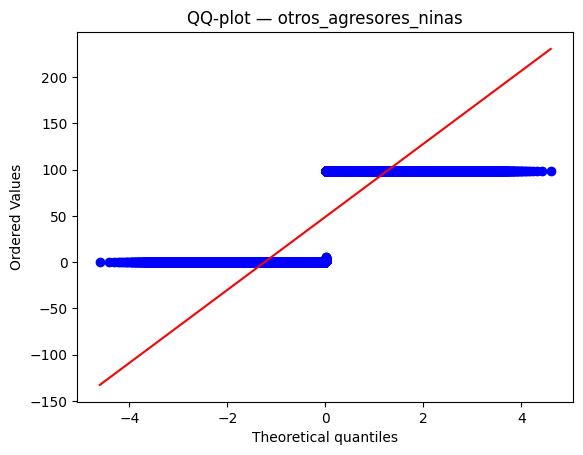

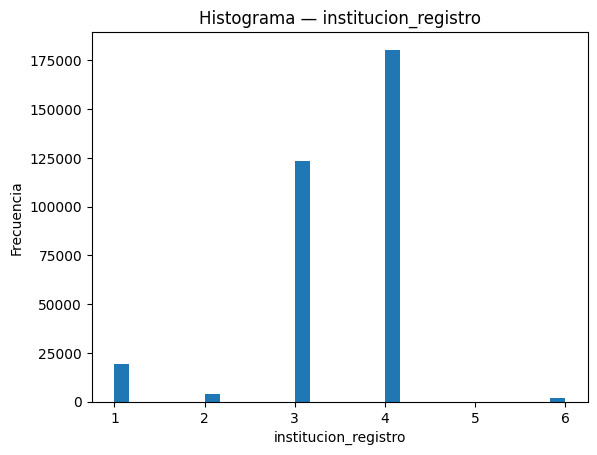

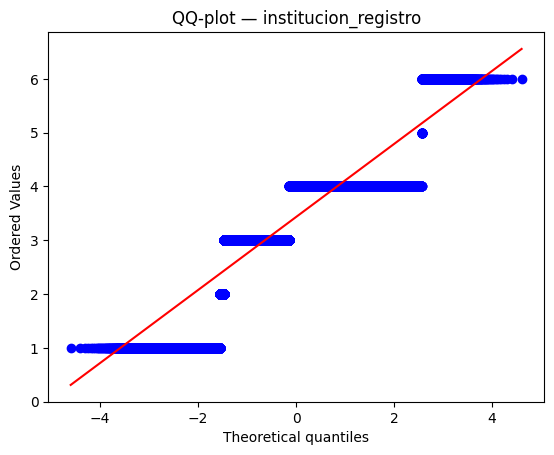

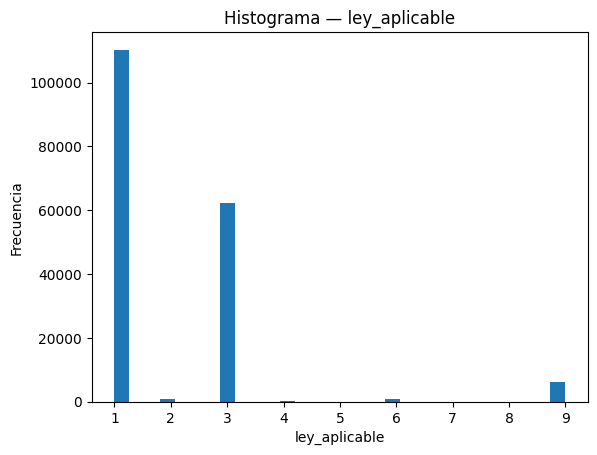

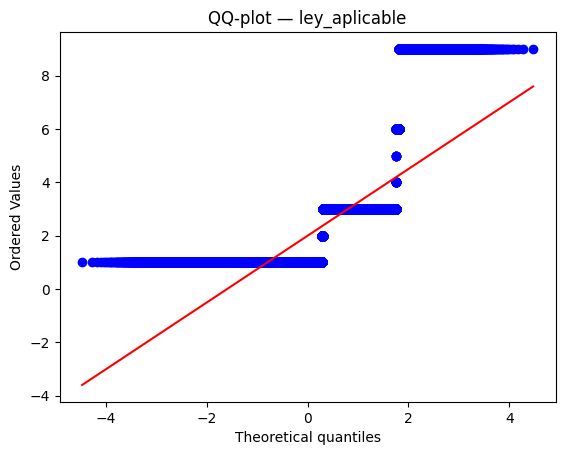

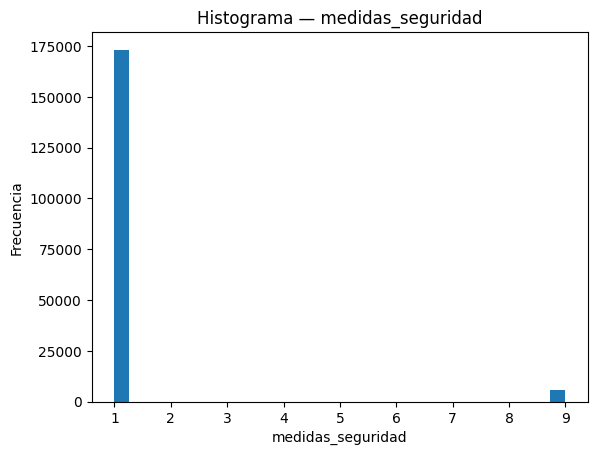

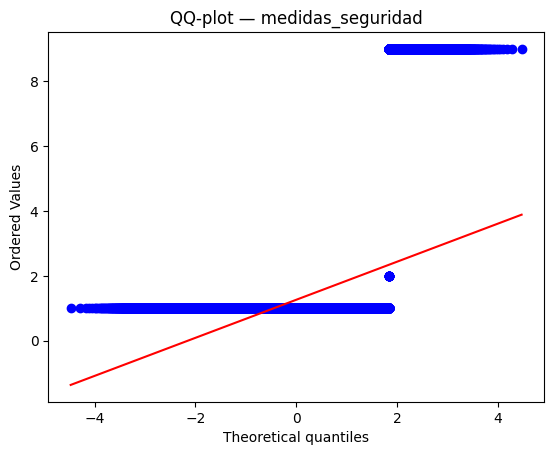

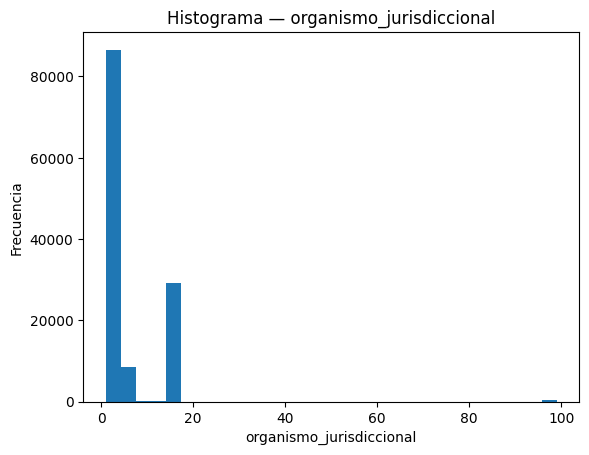

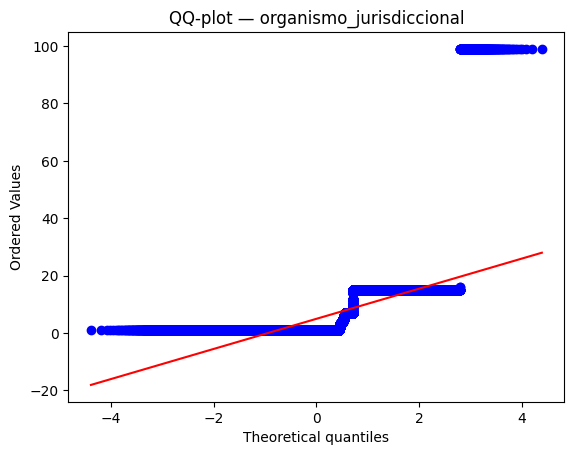

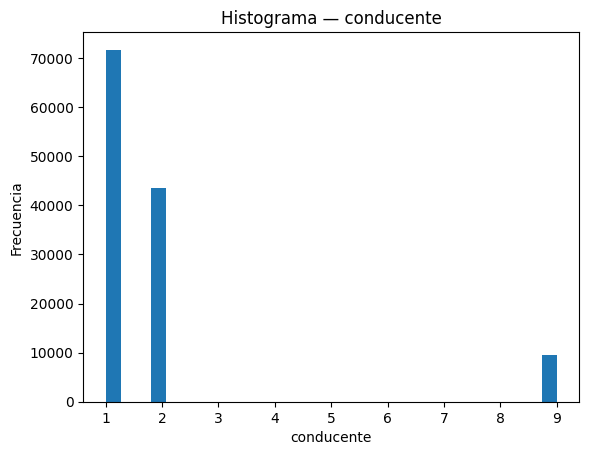

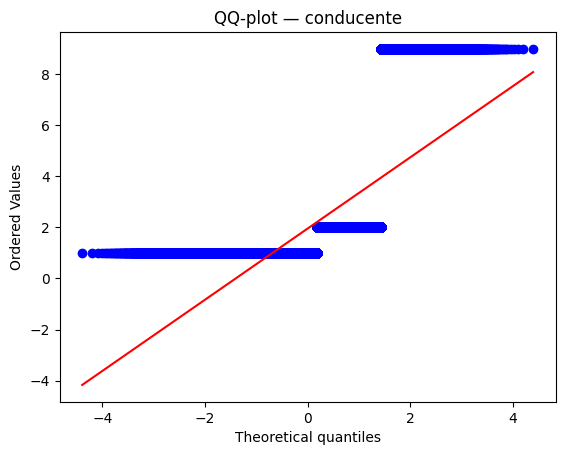

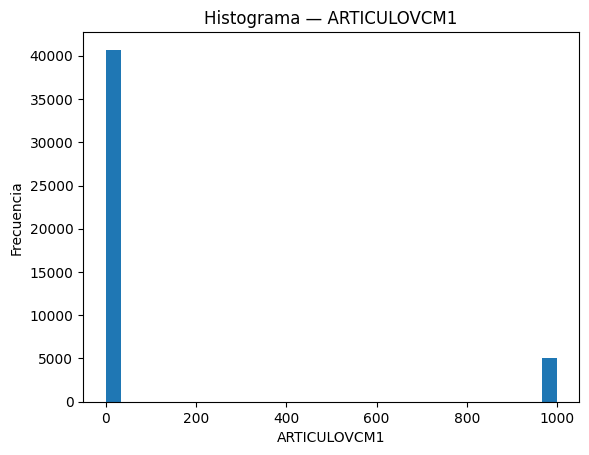

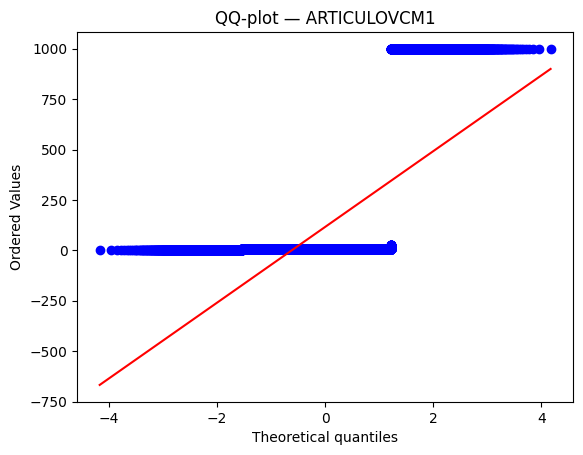

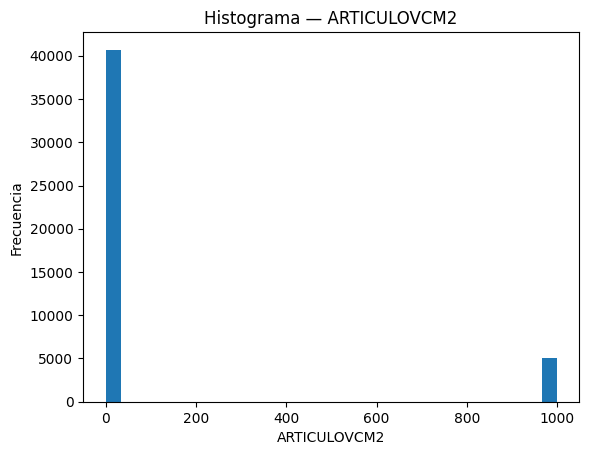

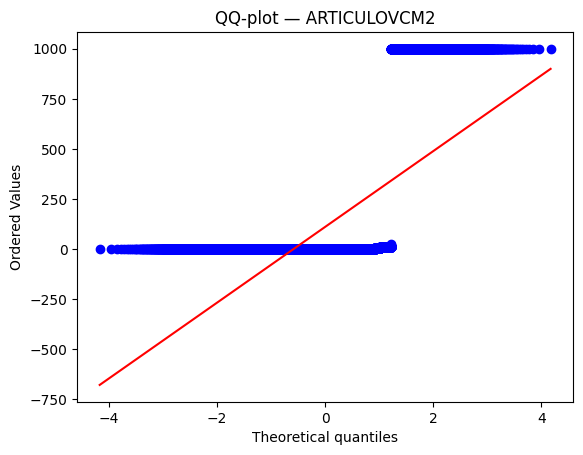

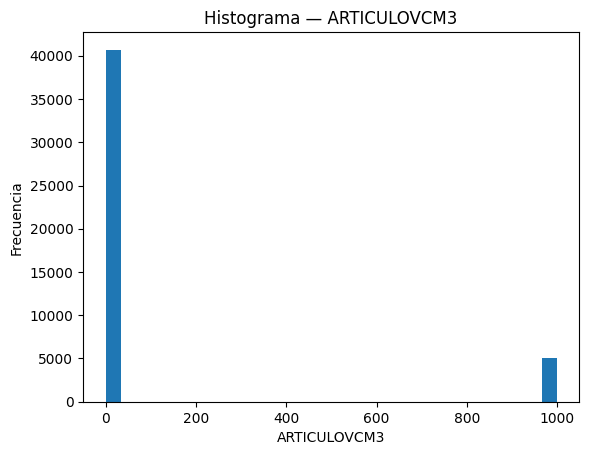

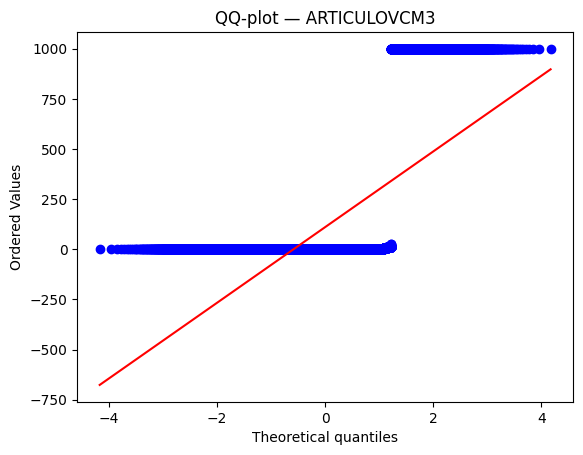

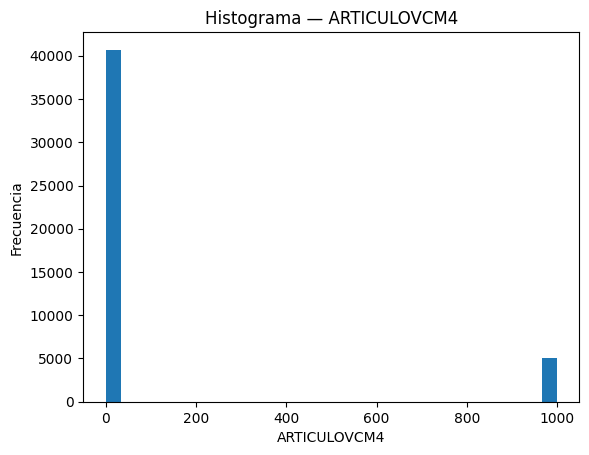

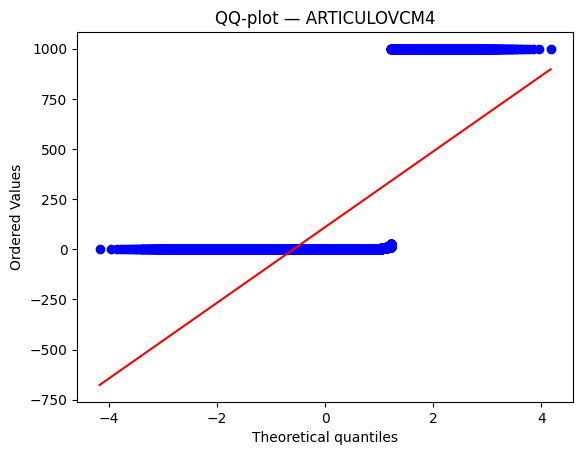

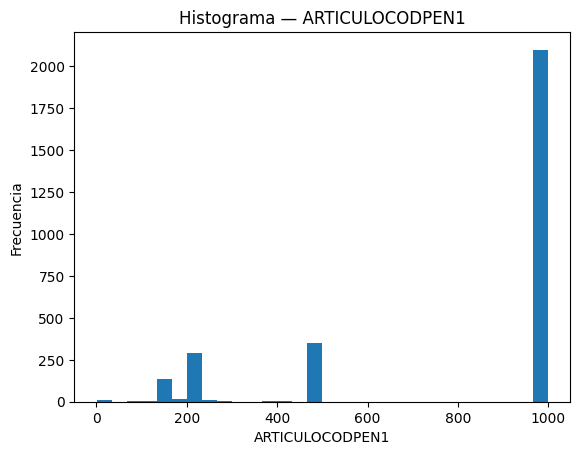

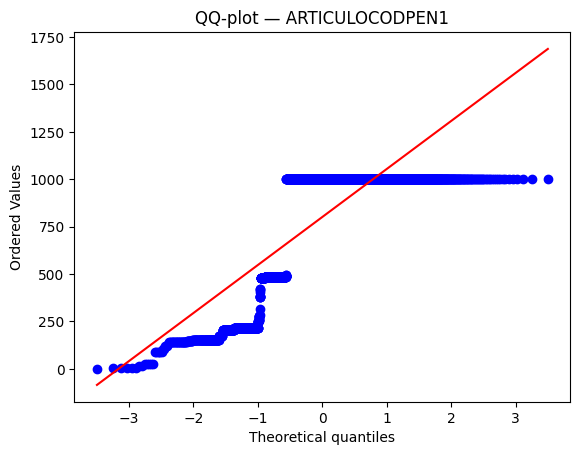

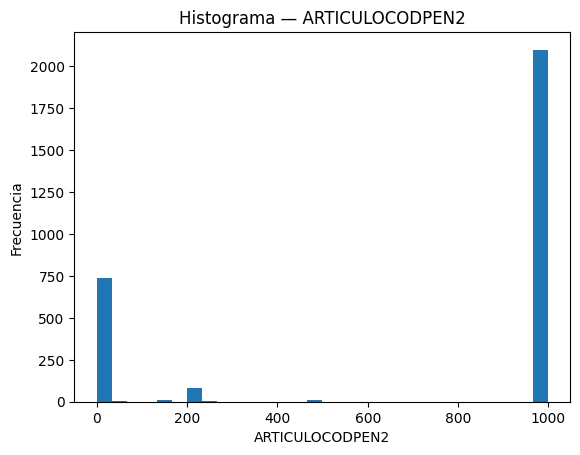

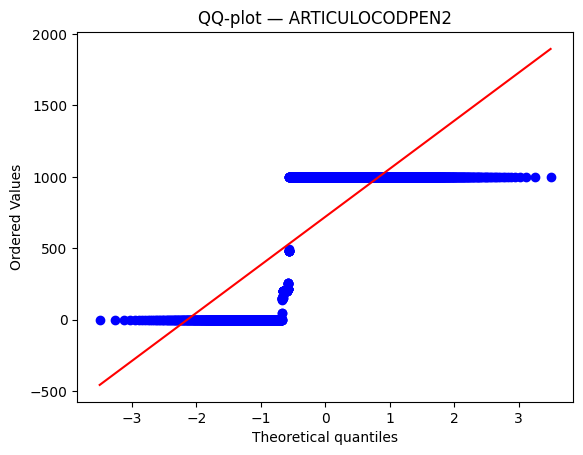

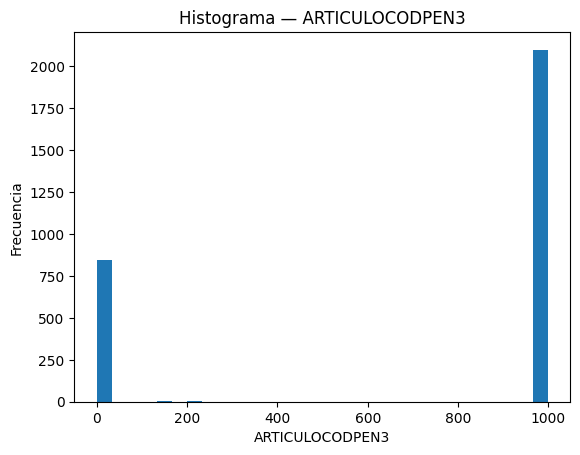

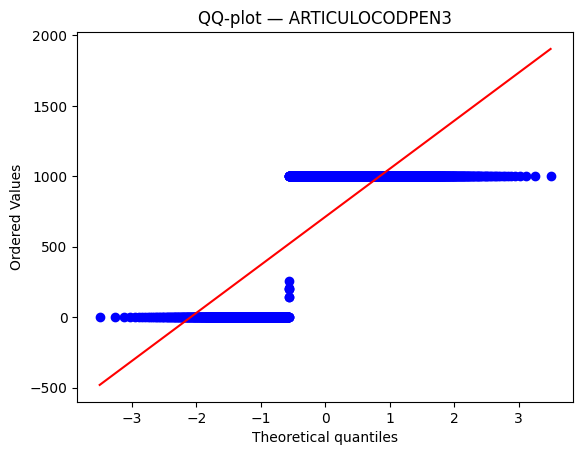

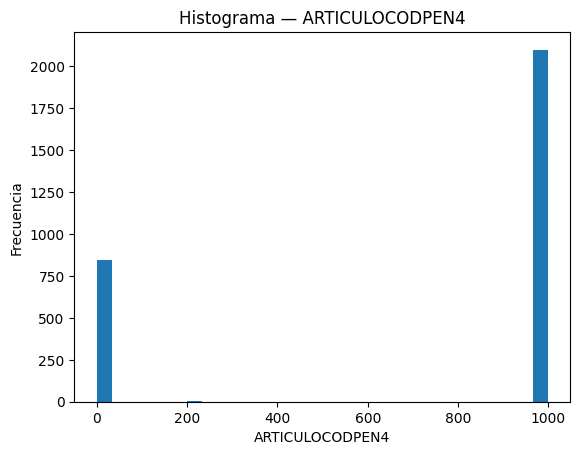

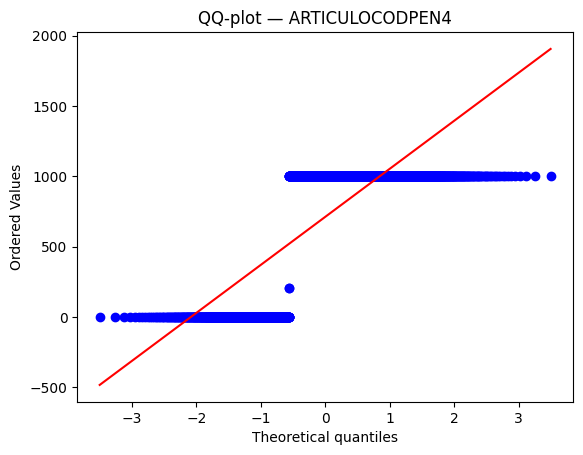

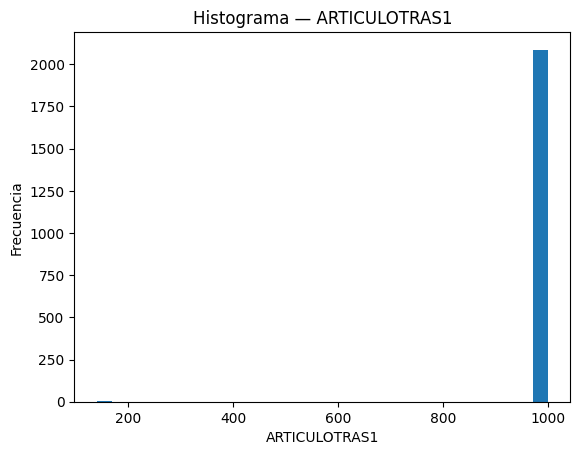

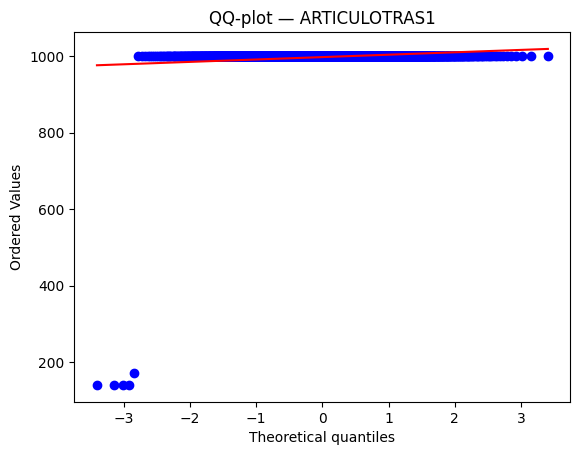

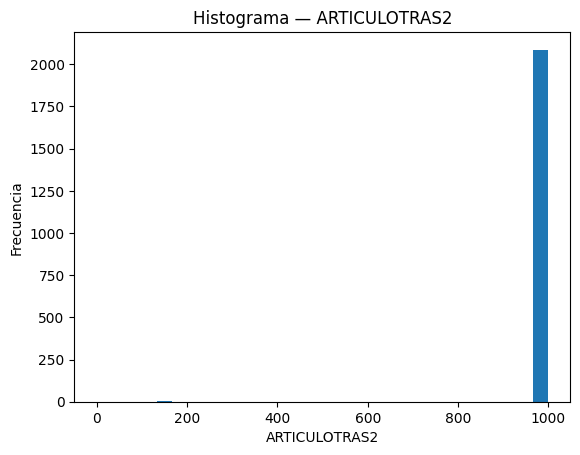

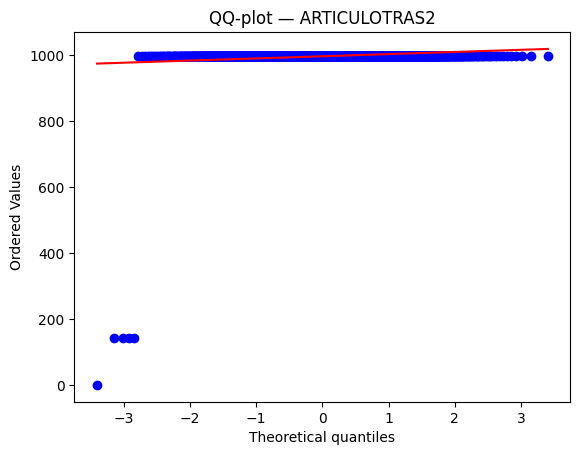

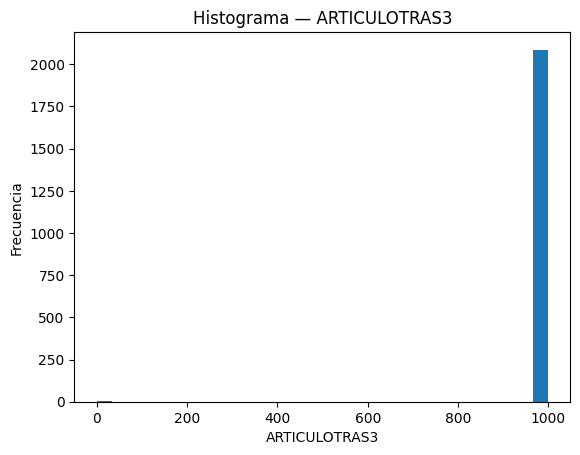

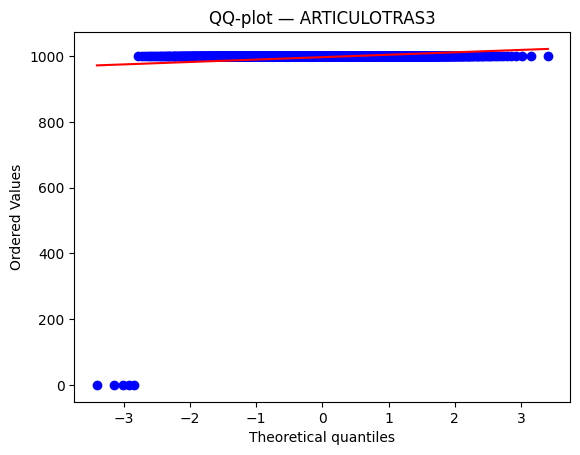

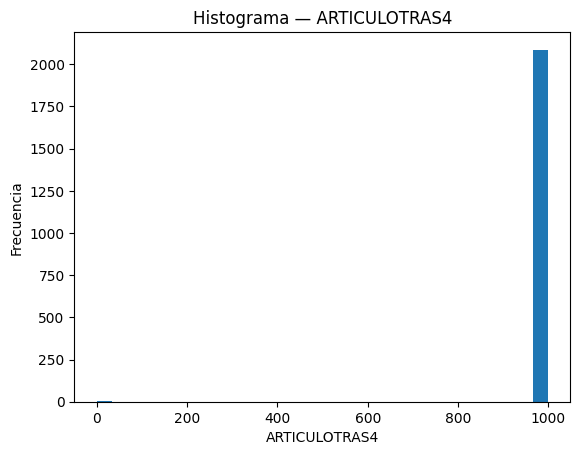

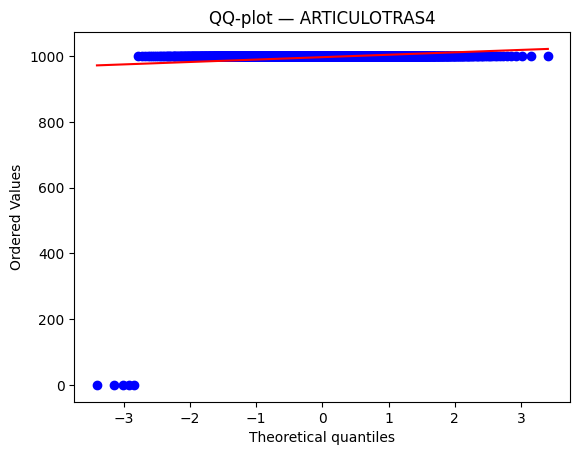

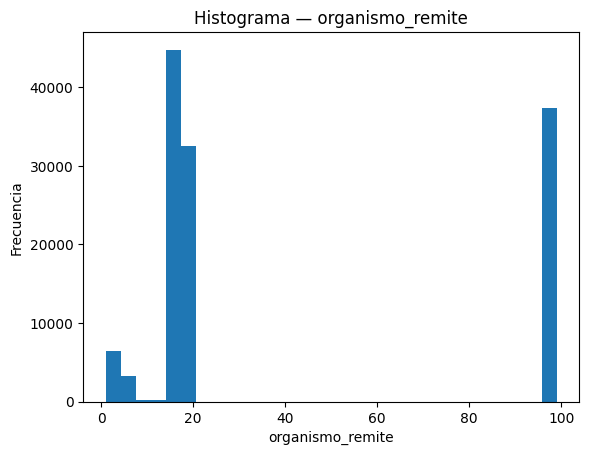

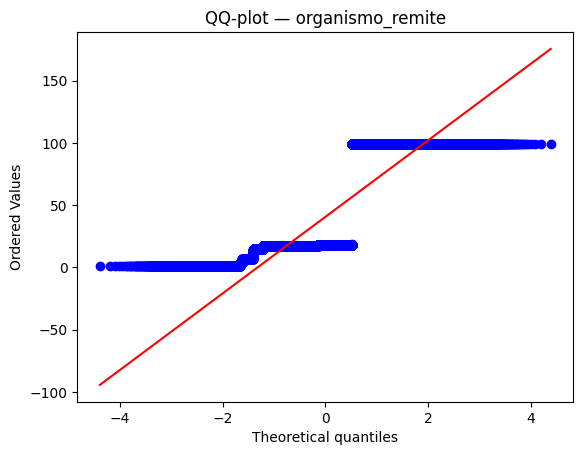

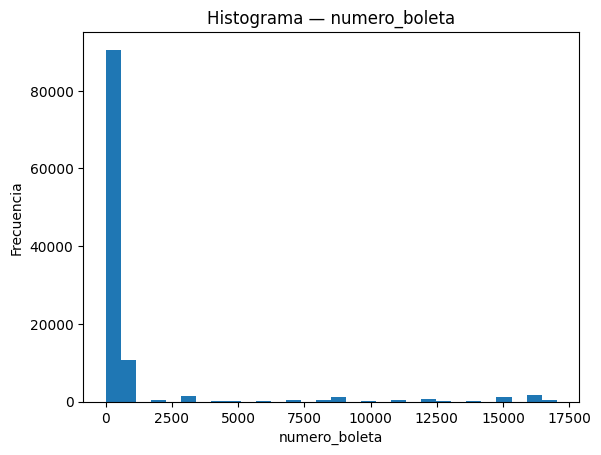

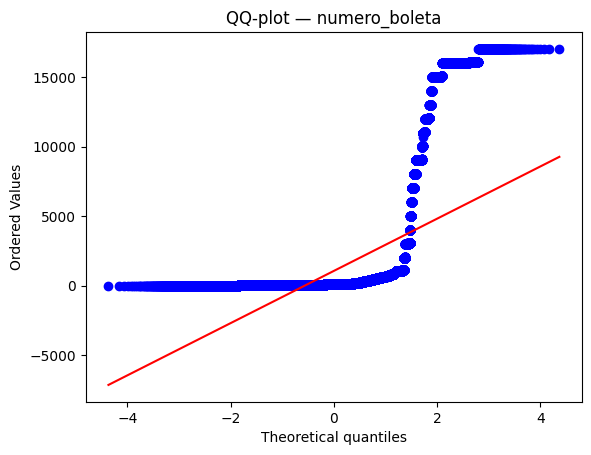

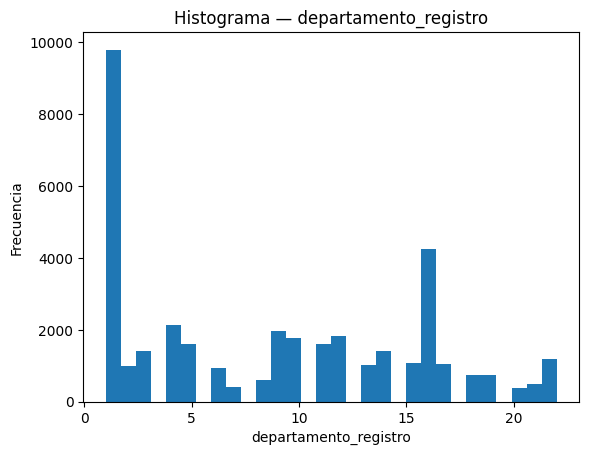

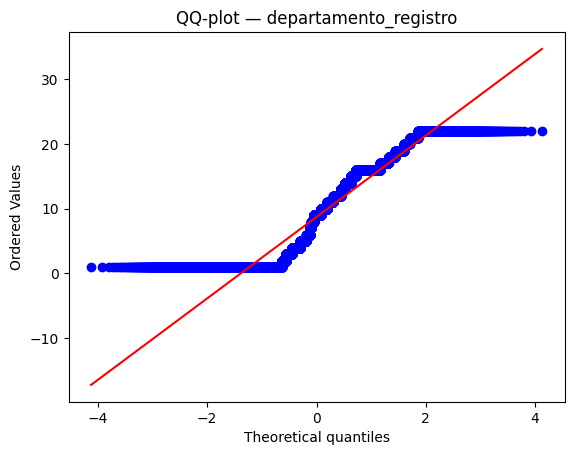

In [32]:
num_cols = df.select_dtypes(include='number').columns.tolist()
print("\n📊 Estadísticas descriptivas — Variables numéricas")
display(df[num_cols].describe().T)

import scipy.stats as stats

print("\n🔬 Prueba de normalidad (Shapiro–Wilk)")
normal_results = []
for col in num_cols:
    data = df[col].dropna()
    if len(data) >= 3:
        stat, p = stats.shapiro(data)
        normal_results.append((col, stat, p))
        print(f"{col}: W={stat:.4f}, p={p:.4f} {'(No normal)' if p<0.05 else '(Normal)'}")
        
for col in num_cols:
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f"Histograma — {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.show()

    plt.figure()
    stats.probplot(df[col].dropna(), dist="norm", plot=plt)
    plt.title(f"QQ‑plot — {col}")
    plt.show()


- Variables categóricas

In [33]:
cat_cols = df.select_dtypes(include='category').columns.tolist()
print("\n📊 Frecuencias — Variables categóricas")
for col in cat_cols:
    print(f"\n== {col} ==")
    display(df[col].value_counts(dropna=False).to_frame("frecuencia"))


📊 Frecuencias — Variables categóricas

== dia_ocurrencia ==


,frecuencia
dia_ocurrencia,
1,13745
2,12169
5,11658
3,11568
15,11545
10,11475
4,11291
20,11182
8,10893



== mes_ocurrencia ==


,frecuencia
mes_ocurrencia,
5,28816
7,28770
8,28355
3,28201
6,27399
4,27306
1,26868
2,26619
9,26467



== anio_ocurrencia ==


,frecuencia
anio_ocurrencia,
2022,36565
2021,36318
2023,35832
2014,33653
2019,31538
2015,31343
2016,30845
2017,29957
2018,29895



== tipo_agresion ==


,frecuencia
tipo_agresion,
2122.0,134890
1122.0,113027
1222.0,36997
1121.0,17034
2121.0,15791
2221.0,3790
1112.0,2220
2112.0,1403
2212.0,1155



== dia_registro ==


,frecuencia
dia_registro,
3,12188
4,11883
5,11715
2,11704
18,11436
6,11420
8,11345
7,11191
11,11006



== mes_registro ==


,frecuencia
mes_registro,
7,29257
8,29088
5,29041
3,28644
6,27724
4,27552
9,26939
1,26898
2,26648



== anio_registro ==


,frecuencia
anio_registro,
2023,37348
2022,37194
2021,36435
2014,34330
2015,31929
2019,31898
2016,31190
2017,30384
2018,29992



== sexo_victima ==


,frecuencia
sexo_victima,
2.0,287813
1.0,41146



== estado_civil_victima ==


,frecuencia
estado_civil_victima,
2.0,131244
3.0,81538
9.0,70013
1.0,32180
5.0,9735
4.0,2575
NaN,1674



== pueblo_victima ==


,frecuencia
pueblo_victima,
1.0,185231
2.0,97351
6.0,39154
9.0,4637
5.0,1632
4.0,508
3.0,446



== nacionalidad_victima ==


,frecuencia
nacionalidad_victima,
1.0,325370
9.0,1962
2.0,1627



== trabaja_victima ==


,frecuencia
trabaja_victima,
2.0,214753
1.0,111856
9.0,1665
NaN,685



== relacion_victima_agresor ==


,frecuencia
relacion_victima_agresor,
2.0,96531
1.0,93698
3.0,54002
10.0,35027
9.0,18482
6.0,15857
4.0,8008
8.0,5472
5.0,1339



== tipo_medida ==


,frecuencia
tipo_medida,
NaN,149851
IJ,110290
AIJ,20239
Z,12343
I,6985
...,...
IJKLM,1
IJKMN,1
IJKÑ,1



== cod_dep_ocurrencia ==


,frecuencia
cod_dep_ocurrencia,
NaN,328959



== cod_mun_ocurrencia ==


,frecuencia
cod_mun_ocurrencia,
NaN,328959



== cod_dep_registro ==


,frecuencia
cod_dep_registro,
NaN,328959



== cod_mun_registro ==


,frecuencia
cod_mun_registro,
NaN,328959
